In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from semopy import Model
from scipy.stats import f_oneway, shapiro, ttest_ind, kruskal, mannwhitneyu

# 0. Load Data

In [2]:
df = pd.read_excel('/Users/maximilianveitl/Documents/Studium/Master/3. Semester/Masterarbeit/Umfrage/Auswertung_final.xlsx', sheet_name='survey_data')
col_description = df[:1]
df = df[1:]
df = df.reset_index()

participants = pd.read_csv('/Users/maximilianveitl/Documents/Studium/Master/3. Semester/Masterarbeit/Umfrage/demographic_data.csv')

# 1. Demographic Analysis

In [3]:
# merge demographic data with survey data
participants = participants.merge(
    df[['RD03_01', 'QUESTNNR', 'STARTED']],
    how='inner',
    left_on='Participant id',
    right_on='RD03_01'
)

# delete duplicates (some participants clicked within prolific multiple times on the SoSci Link; we kept the latest one)
participants['STARTED'] = pd.to_datetime(participants['STARTED'])
participants = participants.sort_values(['RD03_01', 'STARTED'], ascending=[True, False])
participants = participants.drop_duplicates(subset='RD03_01', keep='first')

In [4]:
# in prolific 127 participants - in SoSci 123 participants because 4 participants already dropped out before clicking on the SoSci link
participants['Status'].value_counts()

Status
APPROVED     100
RETURNED      20
TIMED-OUT      2
Name: count, dtype: int64

In [5]:
# Started participants
participants['QUESTNNR'].value_counts()

QUESTNNR
Lineplot      42
Cumulative    41
base          39
Name: count, dtype: int64

In [6]:
# Dropped out participants
participants[participants['Status'] != 'APPROVED']['QUESTNNR'].value_counts()

QUESTNNR
base          8
Lineplot      8
Cumulative    6
Name: count, dtype: int64

In [7]:
# Excluded participants due to missed attention checks are analyzed in 2.4 Drop participants who missed attention checks AND in 3. Summary

# 2. Prepare Data

## 2.1 Drop irrelevant data

In [8]:
# in beiden Datensätzen df und col_description

# drop irrelevant columns
df = df.drop(columns=['index', 'CASE', 'SERIAL', 'REF', 'MODE', 'RD01_CP', 'RD01', 'RD02_RV1', 'T115_01', 'T115_02', 'TY02_02', 'TY02_03', 'TY09_01', 'TIME001', 'TIME002', 
                      'TIME003', 'TIME005', 'TIME007', 'TIME009', 'TIME010', 'TIME011', 'TIME013', 'TIME014', 'MAILSENT', 'LASTDATA', 'STATUS', 
                      'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING', 'MISSREL', 'TIME_RSI', 'TIME039', 'TIME040', 'TIME041'])
col_description = col_description.drop(columns=['CASE', 'SERIAL', 'REF', 'MODE', 'RD01_CP', 'RD01', 'RD02_RV1', 'T115_01', 'T115_02', 'TY02_02', 'TY02_03', 'TY09_01', 'TIME001', 'TIME002', 
                      'TIME003', 'TIME005', 'TIME007', 'TIME009', 'TIME010', 'TIME011', 'TIME013', 'TIME014', 'MAILSENT', 'LASTDATA', 'STATUS', 
                      'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING', 'MISSREL', 'TIME_RSI', 'TIME039', 'TIME040', 'TIME041'])

## 2.2 Rename and reorder columns

In [9]:
new_col_names = ['group', 'started_survey', 't_train_01', 't_train_02_1', 't_train_02_2', 't_train_02_3', 't_train_02_4', 't_train_03_1', 't_train_03_2', 't_train_03_3', 't_train_03_4',
 'prolific_id', 't_train_04', 't_q01_resp', 't_q02_resp', 't_q03_resp', 't_ac_1_resp', 't_q04_resp', 't_q05_resp', 't_q06_resp', 't_q07_resp', 't_ac_2_resp',
 't_q08_resp', 't_q09_resp', 't_q10_resp', 't_q01_hint', 't_q01_corr', 't_q02_hint', 't_q02_corr', 't_q03_hint', 't_q03_corr', 't_ac_1_hint', 't_ac_1_corr', 
 't_q04_hint', 't_q04_corr', 't_q05_hint', 't_q05_corr', 't_q06_hint', 't_q06_corr', 't_q07_hint', 't_q07_corr', 't_ac_2_hint', 't_ac_2_corr', 
 't_q08_hint', 't_q08_corr', 't_q09_hint', 't_q09_corr', 't_q10_hint', 't_q10_corr', 'compensation', 'nasa_1', 'nasa_2', 'nasa_3', 'nasa_5', 'nasa_6', 't_ac_3_resp', 
'nasa_4', 'eou_1', 'eou_2', 'eou_3', 'eou_4', 't_ac_4_resp', 'eou_5', 'eou_6', 'use_1', 'use_2', 'use_3', 'use_4', 'use_5', 'use_6', 't_q01_conf', 't_q02_conf', 
't_q03_conf', 't_ac_1_conf', 't_q04_conf', 't_q05_conf', 't_q06_conf', 't_q07_conf', 't_ac_2_conf', 't_q08_conf', 't_q09_conf', 't_q10_conf', 't_train_01_time', 't_train_02_time', 
't_train_03_time', 't_train_04_time', 't_q01_time', 't_q01_time_hint', 't_q02_time', 't_q02_time_hint', 't_q03_time', 't_q03_time_hint', 't_ac_1_time', 
't_ac_1_time_hint', 't_q04_time', 't_q04_time_hint', 't_q05_time', 't_q05_time_hint', 't_q06_time', 't_q06_time_hint', 't_q07_time', 't_q07_time_hint', 
't_ac_2_time', 't_ac_2_time_hint', 't_q08_time', 't_q08_time_hint', 't_q09_time', 't_q09_time_hint', 't_q10_time', 't_q10_time_hint', 'time_total', 
'finished_survey']

df.columns = new_col_names
col_description.columns = new_col_names

# reorder columns
fixed_order = ['prolific_id', 'group', 'started_survey', 'finished_survey', 'time_total', 'compensation']
t_columns = sorted([col for col in new_col_names if col.startswith('t_')])
nasa_columns = sorted([col for col in new_col_names if col.startswith('nasa')])
eou_columns = sorted([col for col in new_col_names if col.startswith('eou')])
use_columns = sorted([col for col in new_col_names if col.startswith('use')])
reordered_columns = fixed_order + t_columns + nasa_columns + eou_columns + use_columns
df = df[reordered_columns]
col_description = col_description[reordered_columns]

## 2.4 Datentypen anpassen

In [10]:
# convert type to numeric column for hint columns
for i in range(1, 11):
    col = f't_q{i:02d}_hint'
    df[col] = pd.to_numeric(df[col], errors='coerce')


## 2.4 Time von Frage und Hint zusammenfassen

In [11]:
for i in range(1, 11):
    time_col = f't_q{i:02d}_time'
    time_hint_col = f't_q{i:02d}_time_hint'
    
    if time_hint_col in df.columns:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df[time_hint_col] = pd.to_numeric(df[time_hint_col], errors='coerce')
        df[time_col] = df[time_col] + df[time_hint_col].fillna(0)
        df = df.drop(columns=[time_hint_col])

df.head()

,prolific_id,group,started_survey,finished_survey,time_total,compensation,t_ac_1_conf,t_ac_1_corr,t_ac_1_hint,t_ac_1_resp,...,eou_3,eou_4,eou_5,eou_6,use_1,use_2,use_3,use_4,use_5,use_6
0,60b6245e249c0b94ab54dd2e,base,2025-04-11 19:32:40,1,1911,0.75,6,correct,0,4,...,2,4,2,4,6,7,7,6,6,7
1,610e063896c52970e2c24bb5,base,2025-04-11 19:33:48,1,1155,1.25,7,correct,0,4,...,4,5,4,5,5,4,4,5,4,5
2,677fb45dee7e90f416b55aea,base,2025-04-11 19:34:29,1,1256,0.75,4,correct,0,4,...,4,4,4,4,4,4,4,4,4,4
3,5e9aff02f4a78b1a1fe7fc3c,base,2025-04-11 19:35:38,1,1006,1.5,7,correct,0,4,...,1,3,3,3,5,4,4,5,5,4
4,6667410306e83c646df6c338,base,2025-04-11 19:36:29,1,2672,1.5,7,correct,0,4,...,1,4,2,2,5,3,3,2,2,2


## 2.3 Drop not finished participants

In [12]:
df = df[df['finished_survey'] != 0].reset_index(drop=True)

## 2.4 Drop participants who missed attention checks

In [13]:
# for Participant Analysis
# all rows with either t_ac_1_corr != correct or t_ac_1_corr != correct or t_ac_3_resp == 0 or t_ac_4_resp == 0
df[
    (df['t_ac_1_corr'] == 'incorrect') | 
    (df['t_ac_2_corr'] == 'incorrect') | 
    (df['t_ac_3_resp'] != 1) | 
    (df['t_ac_4_resp'] != 1)
]['group'].value_counts()

group
Lineplot      4
Cumulative    3
base          1
Name: count, dtype: int64

In [14]:
excluded_participants = df[
    (df['t_ac_1_corr'] == 'incorrect') | 
    (df['t_ac_2_corr'] == 'incorrect') | 
    (df['t_ac_3_resp'] != 1) | 
    (df['t_ac_4_resp'] != 1)
]['prolific_id']

In [15]:
df = df[df['t_ac_1_corr'] == 'correct']
df = df[df['t_ac_2_corr'] == 'correct']
df = df[df['t_ac_3_resp'] == 1]
df = df[df['t_ac_4_resp'] == 1].reset_index(drop=True)

## 2.5 Split Treatment Groups in different Dataframes

In [16]:
base = df[df['group'] == 'base']
lineplot = df[df['group'] == 'Lineplot']
cumulative = df[df['group'] == 'Cumulative']

# 3. Summary

In [17]:
df.head(5)

,prolific_id,group,started_survey,finished_survey,time_total,compensation,t_ac_1_conf,t_ac_1_corr,t_ac_1_hint,t_ac_1_resp,...,eou_3,eou_4,eou_5,eou_6,use_1,use_2,use_3,use_4,use_5,use_6
0,60b6245e249c0b94ab54dd2e,base,2025-04-11 19:32:40,1,1911,0.75,6,correct,0,4,...,2,4,2,4,6,7,7,6,6,7
1,610e063896c52970e2c24bb5,base,2025-04-11 19:33:48,1,1155,1.25,7,correct,0,4,...,4,5,4,5,5,4,4,5,4,5
2,677fb45dee7e90f416b55aea,base,2025-04-11 19:34:29,1,1256,0.75,4,correct,0,4,...,4,4,4,4,4,4,4,4,4,4
3,5e9aff02f4a78b1a1fe7fc3c,base,2025-04-11 19:35:38,1,1006,1.5,7,correct,0,4,...,1,3,3,3,5,4,4,5,5,4
4,6667410306e83c646df6c338,base,2025-04-11 19:36:29,1,2672,1.5,7,correct,0,4,...,1,4,2,2,5,3,3,2,2,2


In [18]:
# Number of participants per treatment group
df['group'].value_counts()

group
Cumulative    32
base          30
Lineplot      30
Name: count, dtype: int64

In [19]:
participants.head(5)

,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,...,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,RD03_01,QUESTNNR,STARTED
18,67f9539dfd92f5c0aa659476,560f4f3dd4ab1e00126fb989,APPROVED,Not Applicable,2025-04-11T17:38:46.139000Z,2025-04-11T17:50:14.419000Z,2025-04-18T12:17:36Z,2025-04-11T17:50:15.580117Z,689.0,C1DLV2B8,...,Asian,Canada,Canada,Canada,English,No,Full-Time,560f4f3dd4ab1e00126fb989,Cumulative,2025-04-11 19:38:50
89,67f95b83dd73099f4efc16e5,56c65a5a305eaa0005f2a634,RETURNED,Not Applicable,2025-04-11T18:12:30.144000Z,NaN,NaN,2025-04-23T09:34:14.179764Z,NaN,NaN,...,CONSENT_REVOKED,CONSENT_REVOKED,CONSENT_REVOKED,CONSENT_REVOKED,CONSENT_REVOKED,CONSENT_REVOKED,CONSENT_REVOKED,56c65a5a305eaa0005f2a634,base,2025-04-11 20:12:37
121,67f962aeca2af300683fa03a,57dd186e6598aa0001992616,APPROVED,Not Applicable,2025-04-11T18:43:09.204000Z,2025-04-11T18:58:55.529000Z,2025-04-18T12:17:41.255000Z,2025-04-11T18:58:57.346345Z,947.0,C1DLV2B8,...,DATA_EXPIRED,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,57dd186e6598aa0001992616,Cumulative,2025-04-11 20:43:12
52,67f957166f96d22cf47cca45,587b38ec3962c30001276c81,APPROVED,Not Applicable,2025-04-11T17:53:30.592000Z,2025-04-11T18:13:30.136000Z,2025-04-17T17:20:12.996000Z,2025-04-11T18:13:32.264820Z,1200.0,C1DLV2B8,...,White,United Kingdom,United Kingdom,United Kingdom,English,No,DATA_EXPIRED,587b38ec3962c30001276c81,Lineplot,2025-04-11 19:53:35
51,67f956e41ed4629923c8b2cc,58f3d7699fbdde00011e99f7,APPROVED,Not Applicable,2025-04-11T17:52:36.549000Z,2025-04-11T18:20:33.327000Z,2025-04-17T17:49:05.225000Z,2025-04-11T18:20:34.094884Z,1677.0,C1DLV2B8,...,White,United Kingdom,United Kingdom,United Kingdom,English,DATA_EXPIRED,DATA_EXPIRED,58f3d7699fbdde00011e99f7,base,2025-04-11 19:53:08


In [20]:
# % Male per treatment group

# participants without excluded_participants (dropout and attention checks)
participants_reduced = participants[participants['Status'] == 'APPROVED']
participants_reduced = participants_reduced[~participants['Participant id'].isin(excluded_participants)]
participants_reduced.groupby('QUESTNNR')['Sex'].value_counts(normalize=True)

/var/folders/82/kbvzpwhd50j91vkgzn8h3gnr0000gn/T/ipykernel_60583/734275836.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  participants_reduced = participants_reduced[~participants['Participant id'].isin(excluded_participants)]


QUESTNNR    Sex   
Cumulative  Male      0.562500
            Female    0.437500
Lineplot    Female    0.500000
            Male      0.500000
base        Female    0.566667
            Male      0.433333
Name: proportion, dtype: float64

In [21]:
participants_reduced['Sex'].value_counts(normalize=True)

Sex
Male      0.5
Female    0.5
Name: proportion, dtype: float64

In [22]:
participants_reduced['Age'] = pd.to_numeric(participants_reduced['Age'], errors='coerce')
participants_reduced.groupby('QUESTNNR')['Age'].agg(['mean', 'std'])

,mean,std
QUESTNNR,,
Cumulative,39.781250,12.990653
Lineplot,39.633333,15.399246
base,34.333333,11.853512


In [23]:
print(participants_reduced['Age'].mean())
print(participants_reduced['Age'].std())

37.95652173913044
13.574307537822706


# 4. Measures

## 4.1 Accuracy

In [24]:
questions = [f'Q{i}' for i in range(1, 11)]
accuracy = pd.DataFrame(index=questions, columns=['base_abs', 'base_rel', 'lineplot_abs', 'lineplot_rel', 'cumulative_abs', 'cumulative_rel', 'total_abs', 'total_rel'])

# accuracy for each task
for i in range(1, 11):
    question_col = f't_q{i:02d}_corr'

    base_abs = (base[question_col] == 'correct').sum()
    base_total = len(base)
    base_rel = base_abs / base_total

    lineplot_abs = (lineplot[question_col] == 'correct').sum()
    lineplot_total = len(lineplot)
    lineplot_rel = lineplot_abs / lineplot_total

    cumulative_abs = (cumulative[question_col] == 'correct').sum()
    cumulative_total = len(cumulative)
    cumulative_rel = cumulative_abs / cumulative_total

    total_abs = (df[question_col] == 'correct').sum()
    total_total = len(df)
    total_rel = total_abs / total_total

    accuracy.loc[f'Q{i}'] = [base_abs, base_rel, lineplot_abs, lineplot_rel, cumulative_abs, cumulative_rel, total_abs, total_rel]

# accuracy for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}

for category, questions_list in categories.items():
    subset = accuracy.loc[questions_list]

    base_abs = subset['base_abs'].sum()
    lineplot_abs = subset['lineplot_abs'].sum()
    cumulative_abs = subset['cumulative_abs'].sum()
    total_abs = subset['total_abs'].sum()

    base_rel = base_abs / (len(questions_list) * len(base))
    lineplot_rel = lineplot_abs / (len(questions_list) * len(lineplot))
    cumulative_rel = cumulative_abs / (len(questions_list) * len(cumulative))
    total_rel = total_abs / (len(questions_list) * len(df))

    accuracy.loc[category] = [
        base_abs, base_rel,
        lineplot_abs, lineplot_rel,
        cumulative_abs, cumulative_rel,
        total_abs, total_rel
    ]

# total accuracy
subset_all = accuracy.loc[[f'Q{i}' for i in range(1, 11)]]
base_abs = subset_all['base_abs'].sum()
lineplot_abs = subset_all['lineplot_abs'].sum()
cumulative_abs = subset_all['cumulative_abs'].sum()
total_abs = subset_all['total_abs'].sum()

base_rel = base_abs / (10 * len(base))
lineplot_rel = lineplot_abs / (10 * len(lineplot))
cumulative_rel = cumulative_abs / (10 * len(cumulative))
total_rel = total_abs / (10 * len(df))
accuracy.loc['Total'] = [
    base_abs, base_rel,
    lineplot_abs, lineplot_rel,
    cumulative_abs, cumulative_rel,
    total_abs, total_rel
]

accuracy = accuracy.astype({
    'base_abs': 'int',
    'base_rel': 'float',
    'lineplot_abs': 'int',
    'lineplot_rel': 'float',
    'cumulative_abs': 'int',
    'cumulative_rel': 'float',
    'total_abs': 'int',
    'total_rel': 'float'
})
relative_columns = ['base_rel', 'lineplot_rel', 'cumulative_rel', 'total_rel']
accuracy[relative_columns] = accuracy[relative_columns] * 100
accuracy[relative_columns] = accuracy[relative_columns].round(2)

accuracy


,base_abs,base_rel,lineplot_abs,lineplot_rel,cumulative_abs,cumulative_rel,total_abs,total_rel
Q1,15,50.00,22,73.33,23,71.88,60,65.22
Q2,10,33.33,12,40.00,26,81.25,48,52.17
Q3,8,26.67,14,46.67,28,87.50,50,54.35
Q4,14,46.67,17,56.67,29,90.62,60,65.22
Q5,3,10.00,5,16.67,29,90.62,37,40.22
Q6,30,100.00,24,80.00,31,96.88,85,92.39
Q7,24,80.00,19,63.33,31,96.88,74,80.43
Q8,13,43.33,6,20.00,29,90.62,48,52.17
Q9,27,90.00,24,80.00,30,93.75,81,88.04
Q10,20,66.67,19,63.33,27,84.38,66,71.74


## 4.2 Efficiency

In [25]:
efficiency = pd.DataFrame(index=[f'Q{i}' for i in range(1, 11)], columns=['base', 'lineplot', 'cumulative', 'total'])

# efficiency for each task
for i in range(1, 11):
    question_col_corr = f't_q{i:02d}_corr'
    question_col_time = f't_q{i:02d}_time'

    base_correct_times = base.loc[base[question_col_corr] == 'correct', question_col_time]
    lineplot_correct_times = lineplot.loc[lineplot[question_col_corr] == 'correct', question_col_time]
    cumulative_correct_times = cumulative.loc[cumulative[question_col_corr] == 'correct', question_col_time]
    total_correct_times = df.loc[df[question_col_corr] == 'correct', question_col_time]
    
    base_median = base_correct_times.median()
    lineplot_median = lineplot_correct_times.median()
    cumulative_median = cumulative_correct_times.median()
    total_median = total_correct_times.median()

    efficiency.loc[f'Q{i}'] = [base_median, lineplot_median, cumulative_median, total_median]

# efficiency for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}

for category, questions_list in categories.items():
    base_times = []
    lineplot_times = []
    cumulative_times = []

    for i in questions_list:
        q_num = int(i[1:])
        question_col_corr = f't_q{q_num:02d}_corr'
        question_col_time = f't_q{q_num:02d}_time'

        base_times.append(base.loc[base[question_col_corr] == 'correct', question_col_time])
        lineplot_times.append(lineplot.loc[lineplot[question_col_corr] == 'correct', question_col_time])
        cumulative_times.append(cumulative.loc[cumulative[question_col_corr] == 'correct', question_col_time])

    base_times = pd.concat(base_times)
    lineplot_times = pd.concat(lineplot_times)
    cumulative_times = pd.concat(cumulative_times)
    total_times = pd.concat([base_times, lineplot_times, cumulative_times])

    base_median = base_times.median()
    lineplot_median = lineplot_times.median()
    cumulative_median = cumulative_times.median()
    total_median = total_times.median()

    efficiency.loc[category] = [base_median, lineplot_median, cumulative_median, total_median]

# total efficiency
base_times = []
lineplot_times = []
cumulative_times = []

for i in range(1, 11):
    question_col_corr = f't_q{i:02d}_corr'
    question_col_time = f't_q{i:02d}_time'
    base_times.append(base.loc[base[question_col_corr] == 'correct', question_col_time])
    lineplot_times.append(lineplot.loc[lineplot[question_col_corr] == 'correct', question_col_time])
    cumulative_times.append(cumulative.loc[cumulative[question_col_corr] == 'correct', question_col_time])

base_times = pd.concat(base_times)
lineplot_times = pd.concat(lineplot_times)
cumulative_times = pd.concat(cumulative_times)
total_times = pd.concat([base_times, lineplot_times, cumulative_times])

base_median = base_times.median()
lineplot_median = lineplot_times.median()
cumulative_median = cumulative_times.median()
total_median = total_times.median()

efficiency.loc['Total'] = [base_median, lineplot_median, cumulative_median, total_median]

efficiency


,base,lineplot,cumulative,total
Q1,89.0,105.0,40.0,78.0
Q2,95.5,93.5,36.5,63.5
Q3,40.0,101.0,21.0,27.5
Q4,50.0,53.0,20.0,37.0
Q5,94.0,59.0,35.0,37.0
Q6,32.0,31.0,24.0,29.0
Q7,24.5,33.0,15.0,21.0
Q8,58.0,40.5,24.0,27.0
Q9,34.0,28.0,24.5,28.0
Q10,37.5,31.0,26.0,30.0


## 4.3 Confidence

In [26]:
confidence = pd.DataFrame(index=[f'Q{i}' for i in range(1, 11)], columns=['base', 'lineplot', 'cumulative', 'total'])

# confidence for each task
for i in range(1, 11):
    question_col = f't_q{i:02d}_conf'

    base_mean = base[question_col].mean().round(1)
    lineplot_mean = lineplot[question_col].mean().round(1)
    cumulative_mean = cumulative[question_col].mean().round(1)
    total_mean = df[question_col].mean().round(1)

    confidence.loc[f'Q{i}'] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

# confidence for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}
for category, questions_list in categories.items():
    subset = confidence.loc[questions_list]

    base_mean = subset['base'].mean().round(1)
    lineplot_mean = subset['lineplot'].mean().round(1)
    cumulative_mean = subset['cumulative'].mean().round(1)
    total_mean = subset['total'].mean().round(1)

    confidence.loc[category] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

# total confidence
subset_all = confidence.loc[[f'Q{i}' for i in range(1, 11)]]
base_mean = subset_all['base'].mean().round(1)
lineplot_mean = subset_all['lineplot'].mean().round(1)
cumulative_mean = subset_all['cumulative'].mean().round(1)
total_mean = subset_all['total'].mean().round(1)

confidence.loc['Total'] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

confidence

,base,lineplot,cumulative,total
Q1,4.9,4.5,5.7,5.0
Q2,4.8,4.5,5.7,5.0
Q3,5.2,4.8,6.3,5.5
Q4,5.4,5.0,6.5,5.7
Q5,4.4,4.2,6.1,4.9
Q6,5.1,5.1,6.1,5.5
Q7,5.2,5.1,6.4,5.6
Q8,5.4,5.8,6.2,5.8
Q9,5.4,4.8,6.0,5.4
Q10,5.1,5.3,6.0,5.5


## 4.4 Hint needed

In [27]:
questions = [f'Q{i}' for i in range(1, 11)]
hint_needed = pd.DataFrame(index=questions, columns=['base_abs', 'base_rel', 'lineplot_abs', 'lineplot_rel', 'cumulative_abs', 'cumulative_rel', 'total_abs', 'total_rel'])

#  for each task
for i in range(1, 11):
    question_col = f't_q{i:02d}_hint'

    base_abs = base[question_col].sum()
    base_total = len(base)
    base_rel = base_abs / base_total

    lineplot_abs = lineplot[question_col].sum()
    lineplot_total = len(lineplot)
    lineplot_rel = lineplot_abs / lineplot_total

    cumulative_abs = cumulative[question_col].sum()
    cumulative_total = len(cumulative)
    cumulative_rel = cumulative_abs / cumulative_total

    total_abs = df[question_col].sum()
    total_total = len(df)
    total_rel = total_abs / total_total

    hint_needed.loc[f'Q{i}'] = [base_abs, base_rel, lineplot_abs, lineplot_rel, cumulative_abs, cumulative_rel, total_abs, total_rel]

# hint_needed for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}

for category, questions_list in categories.items():
    subset = hint_needed.loc[questions_list]

    base_abs = subset['base_abs'].sum()
    lineplot_abs = subset['lineplot_abs'].sum()
    cumulative_abs = subset['cumulative_abs'].sum()
    total_abs = subset['total_abs'].sum()

    base_rel = base_abs / (len(questions_list) * len(base))
    lineplot_rel = lineplot_abs / (len(questions_list) * len(lineplot))
    cumulative_rel = cumulative_abs / (len(questions_list) * len(cumulative))
    total_rel = total_abs / (len(questions_list) * len(df))

    hint_needed.loc[category] = [
        base_abs, base_rel,
        lineplot_abs, lineplot_rel,
        cumulative_abs, cumulative_rel,
        total_abs, total_rel
    ]

# total hint_needed
subset_all = hint_needed.loc[[f'Q{i}' for i in range(1, 11)]]
base_abs = subset_all['base_abs'].sum()
lineplot_abs = subset_all['lineplot_abs'].sum()
cumulative_abs = subset_all['cumulative_abs'].sum()
total_abs = subset_all['total_abs'].sum()

base_rel = base_abs / (10 * len(base))
lineplot_rel = lineplot_abs / (10 * len(lineplot))
cumulative_rel = cumulative_abs / (10 * len(cumulative))
total_rel = total_abs / (10 * len(df))
hint_needed.loc['Total'] = [
    base_abs, base_rel,
    lineplot_abs, lineplot_rel,
    cumulative_abs, cumulative_rel,
    total_abs, total_rel
]

hint_needed = hint_needed.astype({
    'base_abs': 'int',
    'base_rel': 'float',
    'lineplot_abs': 'int',
    'lineplot_rel': 'float',
    'cumulative_abs': 'int',
    'cumulative_rel': 'float',
    'total_abs': 'int',
    'total_rel': 'float'
})
relative_columns = ['base_rel', 'lineplot_rel', 'cumulative_rel', 'total_rel']
hint_needed[relative_columns] = hint_needed[relative_columns] * 100
hint_needed[relative_columns] = hint_needed[relative_columns].round(2)

hint_needed


,base_abs,base_rel,lineplot_abs,lineplot_rel,cumulative_abs,cumulative_rel,total_abs,total_rel
Q1,4,13.33,5,16.67,4,12.50,13,14.13
Q2,1,3.33,2,6.67,0,0.00,3,3.26
Q3,1,3.33,2,6.67,1,3.12,4,4.35
Q4,2,6.67,1,3.33,1,3.12,4,4.35
Q5,4,13.33,4,13.33,1,3.12,9,9.78
Q6,1,3.33,1,3.33,1,3.12,3,3.26
Q7,1,3.33,0,0.00,1,3.12,2,2.17
Q8,0,0.00,0,0.00,1,3.12,1,1.09
Q9,0,0.00,1,3.33,0,0.00,1,1.09
Q10,0,0.00,1,3.33,1,3.12,2,2.17


## 4.5 Composite Score
score = 50 * accuracy + 30 * max(0, 1 - time / 180) - 20 * (1 - hint_needed)

In [28]:
df_cscore = df.loc[:, ['prolific_id', 'group']]
for i in range(1, 11):
    acc_col = f't_q{i:02d}_corr'
    time_col = f't_q{i:02d}_time'
    hint_col = f't_q{i:02d}_hint'
    df_score = (
        50 * df[acc_col].map({'correct': 1, 'incorrect': 0}) 
        + 30 * (1 - (df[time_col] / 180)).clip(lower=0) 
        + 20 * (1 - df[hint_col]))
    df_cscore[f'Q{i}'] = df_score

base_cscore = df_cscore[df_cscore['group'] == 'base']
lineplot_cscore = df_cscore[df_cscore['group'] == 'Lineplot']
cumulative_cscore = df_cscore[df_cscore['group'] == 'Cumulative']

In [29]:
compscore = pd.DataFrame(index=[f'Q{i}' for i in range(1, 11)], columns=['base', 'lineplot', 'cumulative', 'total'])

# compscore for each task
for i in range(1, 11):
    question_col = f'Q{i}'

    base_mean = base_cscore[question_col].mean().round(1)
    lineplot_mean = lineplot_cscore[question_col].mean().round(1)
    cumulative_mean = cumulative_cscore[question_col].mean().round(1)
    total_mean = df_cscore[question_col].mean().round(1)

    compscore.loc[f'Q{i}'] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

# compscore for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}
for category, questions_list in categories.items():
    subset = compscore.loc[questions_list]

    base_mean = subset['base'].mean().round(1)
    lineplot_mean = subset['lineplot'].mean().round(1)
    cumulative_mean = subset['cumulative'].mean().round(1)
    total_mean = subset['total'].mean().round(1)

    compscore.loc[category] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

# total compscore
subset_all = compscore.loc[[f'Q{i}' for i in range(1, 11)]]
base_mean = subset_all['base'].mean().round(1)
lineplot_mean = subset_all['lineplot'].mean().round(1)
cumulative_mean = subset_all['cumulative'].mean().round(1)
total_mean = subset_all['total'].mean().round(1)

compscore.loc['Total'] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

compscore


,base,lineplot,cumulative,total
Q1,52.9,66.6,73.7,64.6
Q2,50.5,53.7,82.9,62.8
Q3,52.1,56.8,87.3,65.9
Q4,63.7,68.7,89.2,74.2
Q5,37.9,41.7,86.1,55.9
Q6,91.4,82.7,92.7,89.0
Q7,83.7,75.5,94.3,84.7
Q8,65.0,54.2,89.9,70.2
Q9,88.7,83.2,92.8,88.3
Q10,76.2,75.4,86.8,79.6


## 4.6 Confidence-Accuracy Relationship

In [30]:
from scipy.stats import spearmanr

SpearmanTable = pd.DataFrame(index=[f'Q{i}' for i in range(1, 11)], columns=['base_corr', 'base_p', 'lineplot_corr', 'lineplot_p', 'cumulative_corr', 'cumulative_p', 'total_corr', 'total_p'])

# Spearman correlation for each task
for i in range(1, 11):
    conf_col = f't_q{i:02d}_conf'
    corr_col = f't_q{i:02d}_corr'

    base_conf = base[conf_col]
    base_acc = base[corr_col].map({'correct': 1, 'incorrect': 0})
    base_corr, base_p = spearmanr(base_conf, base_acc)

    lineplot_conf = lineplot[conf_col]
    lineplot_acc = lineplot[corr_col].map({'correct': 1, 'incorrect': 0})
    lineplot_corr, lineplot_p = spearmanr(lineplot_conf, lineplot_acc)

    cumulative_conf = cumulative[conf_col]
    cumulative_acc = cumulative[corr_col].map({'correct': 1, 'incorrect': 0})
    cumulative_corr, cumulative_p = spearmanr(cumulative_conf, cumulative_acc)

    total_conf = df[conf_col]
    total_acc = df[corr_col].map({'correct': 1, 'incorrect': 0})
    total_corr, total_p = spearmanr(total_conf, total_acc)

    SpearmanTable.loc[f'Q{i}'] = [base_corr, base_p, lineplot_corr, lineplot_p, cumulative_corr, cumulative_p, total_corr, total_p]

# Spearman correlation for each task category
categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}

for category, questions_list in categories.items():
    base_conf = []
    base_acc = []
    lineplot_conf = []
    lineplot_acc = []
    cumulative_conf = []
    cumulative_acc = []
    total_conf = []
    total_acc = []

    for q in questions_list:
        i = int(q[1:])
        conf_col = f't_q{i:02d}_conf'
        corr_col = f't_q{i:02d}_corr'

        base_conf.append(base[conf_col])
        base_acc.append(base[corr_col].map({'correct': 1, 'incorrect': 0}))
        lineplot_conf.append(lineplot[conf_col])
        lineplot_acc.append(lineplot[corr_col].map({'correct': 1, 'incorrect': 0}))
        cumulative_conf.append(cumulative[conf_col])
        cumulative_acc.append(cumulative[corr_col].map({'correct': 1, 'incorrect': 0}))
        total_conf.append(df[conf_col])
        total_acc.append(df[corr_col].map({'correct': 1, 'incorrect': 0}))

    base_conf = pd.concat(base_conf)
    base_acc = pd.concat(base_acc)
    base_corr, base_p = spearmanr(base_conf, base_acc)

    lineplot_conf = pd.concat(lineplot_conf)
    lineplot_acc = pd.concat(lineplot_acc)
    lineplot_corr, lineplot_p = spearmanr(lineplot_conf, lineplot_acc)

    cumulative_conf = pd.concat(cumulative_conf)
    cumulative_acc = pd.concat(cumulative_acc)
    cumulative_corr, cumulative_p = spearmanr(cumulative_conf, cumulative_acc)

    total_conf = pd.concat(total_conf)
    total_acc = pd.concat(total_acc)
    total_corr, total_p = spearmanr(total_conf, total_acc)

    SpearmanTable.loc[category] = [base_corr, base_p, lineplot_corr, lineplot_p, cumulative_corr, cumulative_p, total_corr, total_p]

# Spearman correlation for all tasks
base_conf = []
base_acc = []
lineplot_conf = []
lineplot_acc = []
cumulative_conf = []
cumulative_acc = []
total_conf = []
total_acc = []
for i in range(1, 11):
    conf_col = f't_q{i:02d}_conf'
    corr_col = f't_q{i:02d}_corr'

    base_conf.append(base[conf_col])
    base_acc.append(base[corr_col].map({'correct': 1, 'incorrect': 0}))
    lineplot_conf.append(lineplot[conf_col])
    lineplot_acc.append(lineplot[corr_col].map({'correct': 1, 'incorrect': 0}))
    cumulative_conf.append(cumulative[conf_col])
    cumulative_acc.append(cumulative[corr_col].map({'correct': 1, 'incorrect': 0}))
    total_conf.append(df[conf_col])
    total_acc.append(df[corr_col].map({'correct': 1, 'incorrect': 0}))

base_conf = pd.concat(base_conf)
base_acc = pd.concat(base_acc)
base_corr, base_p = spearmanr(base_conf, base_acc)
lineplot_conf = pd.concat(lineplot_conf)
lineplot_acc = pd.concat(lineplot_acc)
lineplot_corr, lineplot_p = spearmanr(lineplot_conf, lineplot_acc)
cumulative_conf = pd.concat(cumulative_conf)
cumulative_acc = pd.concat(cumulative_acc)
cumulative_corr, cumulative_p = spearmanr(cumulative_conf, cumulative_acc)
total_conf = pd.concat(total_conf)
total_acc = pd.concat(total_acc)
total_corr, total_p = spearmanr(total_conf, total_acc)

SpearmanTable.loc['Total'] = [base_corr, base_p, lineplot_corr, lineplot_p, cumulative_corr, cumulative_p, total_corr, total_p]

SpearmanTable

/var/folders/82/kbvzpwhd50j91vkgzn8h3gnr0000gn/T/ipykernel_60583/1893342702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  base_corr, base_p = spearmanr(base_conf, base_acc)


,base_corr,base_p,lineplot_corr,lineplot_p,cumulative_corr,cumulative_p,total_corr,total_p
Q1,0.235764,0.209757,0.141692,0.455135,0.332204,0.063224,0.24291,0.019642
Q2,0.066667,0.726322,0.195422,0.300712,0.230938,0.203486,0.267975,0.009806
Q3,0.102731,0.589056,0.035894,0.850636,0.103074,0.574542,0.226596,0.029852
Q4,0.064033,0.736747,-0.007924,0.966852,0.022142,0.904256,0.153964,0.14283
Q5,0.431124,0.01738,0.136324,0.472564,0.508207,0.002981,0.53022,0.0
Q6,NaN,NaN,0.439325,0.015141,-0.150842,0.409898,0.200885,0.054845
Q7,0.368397,0.045163,0.575311,0.000881,0.214074,0.239392,0.48734,0.000001
Q8,0.148953,0.432115,-0.105311,0.579684,0.12722,0.487769,0.115093,0.274624
Q9,0.278126,0.136706,0.039532,0.835695,0.26311,0.145687,0.198892,0.057347
Q10,0.390862,0.032707,-0.156711,0.408238,0.204964,0.260452,0.187174,0.074003


## 4.7 NASA-TLX

In [31]:
dimensions = [
    'Mental Demand',
    'Physical Demand',
    'Temporal Demand',
    'Performance',
    'Effort',
    'Frustration'
]

NASA_TLX = pd.DataFrame(index=dimensions, columns=['base', 'lineplot', 'cumulative', 'total'])

for i, dimension in enumerate(dimensions, start=1):
    col = f'nasa_{i}'
    base_mean = base[col].mean().round(2)
    lineplot_mean = lineplot[col].mean().round(2)
    cumulative_mean = cumulative[col].mean().round(2)
    total_mean = df[col].mean().round(2)
    NASA_TLX.loc[dimension] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

base_mean = NASA_TLX.loc[dimensions, 'base'].mean().round(2)
lineplot_mean = NASA_TLX.loc[dimensions, 'lineplot'].mean().round(2)
cumulative_mean = NASA_TLX.loc[dimensions, 'cumulative'].mean().round(2)
total_mean = NASA_TLX.loc[dimensions, 'total'].mean().round(2)

NASA_TLX.loc['Total'] = [base_mean, lineplot_mean, cumulative_mean, total_mean]

NASA_TLX


,base,lineplot,cumulative,total
Mental Demand,5.9,5.97,4.22,5.34
Physical Demand,3.03,2.43,1.81,2.41
Temporal Demand,3.8,3.33,2.5,3.2
Performance,4.1,4.13,2.25,3.47
Effort,5.73,5.57,4.56,5.27
Frustration,3.97,4.07,2.06,3.34
Total,4.42,4.25,2.9,3.84


## 4.8 Ease of Use

In [32]:
# Confirmatory Factor Analysis to test whether the ease of use items load on the expected factors

ease_of_use_items = ['eou_1', 'eou_2', 'eou_3', 'eou_4', 'eou_5', 'eou_6']

df[ease_of_use_items] = df[ease_of_use_items].apply(pd.to_numeric, errors='coerce')

model_desc = """
Ease_of_Use =~ eou_1 + eou_2 + eou_3 + eou_4 + eou_5 + eou_6
"""

cfa_model = Model(model_desc)
cfa_model.fit(df[ease_of_use_items])

report = cfa_model.inspect()
report

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,eou_1,~,Ease_of_Use,1.000000,-,-,-
1,eou_2,~,Ease_of_Use,0.963407,0.057843,16.655646,0.0
2,eou_3,~,Ease_of_Use,0.925868,0.065183,14.204112,0.0
3,eou_4,~,Ease_of_Use,0.748866,0.088863,8.427174,0.0
4,eou_5,~,Ease_of_Use,0.867786,0.057391,15.120532,0.0
5,eou_6,~,Ease_of_Use,0.867040,0.057353,15.117481,0.0
6,Ease_of_Use,~~,Ease_of_Use,2.364979,0.412406,5.734586,0.0
7,eou_1,~~,eou_1,0.449725,0.081504,5.517793,0.0
8,eou_2,~~,eou_2,0.267120,0.055666,4.798661,0.000002
9,eou_3,~~,eou_3,0.494247,0.085193,5.801522,0.0


In [33]:
# -> 6 Items messen gleiches Konstrukt, da Estimate > 0.85

ease_of_use_scores = df[ease_of_use_items + ['group']].groupby('group').mean().mean(axis=1)

ease_of_use_scores

group
Cumulative    6.052083
Lineplot      4.627778
base          4.396552
dtype: float64

## 4.9 Usefulness

Habe ich in Masterarbeit nicht weiter berücksichtigt.

In [34]:
# Confirmatory Factor Analysis to test whether the usefulness items load on the expected factors

use_items = ['use_1', 'use_2', 'use_3', 'use_4', 'use_5', 'use_6']

df[use_items] = df[use_items].apply(pd.to_numeric, errors='coerce')

model_desc = """
Ease_of_Use =~ use_1 + use_2 + use_3 + use_4 + use_5 + use_6
"""

cfa_model = Model(model_desc)
cfa_model.fit(df[use_items])

report = cfa_model.inspect()
report

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,use_1,~,Ease_of_Use,1.000000,-,-,-
1,use_2,~,Ease_of_Use,1.273609,0.132374,9.621258,0.0
2,use_3,~,Ease_of_Use,1.348980,0.132417,10.187345,0.0
3,use_4,~,Ease_of_Use,1.333537,0.130788,10.196196,0.0
4,use_5,~,Ease_of_Use,1.271643,0.140864,9.027486,0.0
5,use_6,~,Ease_of_Use,1.400108,0.136776,10.236517,0.0
6,Ease_of_Use,~~,Ease_of_Use,0.872529,0.202104,4.317224,0.000016
7,use_1,~~,use_1,0.617789,0.09569,6.45617,0.0
8,use_2,~~,use_2,0.350776,0.060088,5.837752,0.0
9,use_3,~~,use_3,0.227117,0.044314,5.125219,0.0


In [35]:
# -> 6 Items messen gleiches Konstrukt, da Estimate > 0.85

usefulness_scores = df[use_items + ['group']].groupby('group').mean().mean(axis=1)

usefulness_scores

group
Cumulative    6.276042
Lineplot      5.185441
base          5.127778
dtype: float64

# 5. Analysis

## 5.1 Hypothesis 2

### 5.1.1 Accuracy Hilfsmatrix

In [36]:
# Hilfsmatrix erstellen
categories = {
    'Simple Value': ['t_q01_corr', 't_q02_corr'],
    'Comparison': ['t_q03_corr', 't_q04_corr', 't_q05_corr'],
    'Pattern Recognition': ['t_q06_corr', 't_q07_corr', 't_q08_corr'],
    'Bounded Inference': ['t_q09_corr', 't_q10_corr']
}

participants_accuracy = pd.DataFrame(index=df.index)

participants_accuracy['group'] = df['group']

df_numeric = df.copy()
for col in [f't_q{i:02d}_corr' for i in range(1, 11)]:
    df_numeric[col] = df[col].map({'correct': 1, 'incorrect': 0})

for cat_name, question_cols in categories.items():
    participants_accuracy[cat_name] = df_numeric[question_cols].mean(axis=1)

participants_accuracy['Accuracy total'] = df_numeric[[f't_q{i:02d}_corr' for i in range(1, 11)]].mean(axis=1)

participants_accuracy.head()

,group,Simple Value,Comparison,Pattern Recognition,Bounded Inference,Accuracy total
0,base,0.0,0.333333,0.333333,0.5,0.3
1,base,1.0,0.333333,0.333333,0.5,0.5
2,base,0.0,0.000000,0.666667,0.5,0.3
3,base,1.0,0.000000,0.666667,1.0,0.6
4,base,0.0,0.333333,1.000000,1.0,0.6


### 5.1.2 Test Normalverteilung zur Bestimmung ANOVA oder Kruskal-Wallis-Test sowie t-Test oder Mann-Whitney-U-Test

In [37]:
# Testen, ob Daten normalverteilt, um zu bestimmen ob ANOVA oder Kruskal-Wallis-Test sowie t-Test oder Mann-Whitney-U-Test
for group_name in ['base', 'Lineplot', 'Cumulative']:
    data = participants_accuracy.loc[participants_accuracy['group'] == group_name, 'Accuracy total']
    stat, p = shapiro(data)
    print(f"{group_name}: W = {stat:.3f}, p = {p:.4f}")

base: W = 0.945, p = 0.1205
Lineplot: W = 0.921, p = 0.0290
Cumulative: W = 0.690, p = 0.0000


### 5.1.3 Kruskal-Wallis-Test

In [38]:
# Lineplot und Cumulative sind nicht normalverteilt -> Kruskal-Wallis-Test auf Accuracy total
base_accuracy = participants_accuracy.loc[participants_accuracy['group'] == 'base', 'Accuracy total']
lineplot_accuracy = participants_accuracy.loc[participants_accuracy['group'] == 'Lineplot', 'Accuracy total']
cumulative_accuracy = participants_accuracy.loc[participants_accuracy['group'] == 'Cumulative', 'Accuracy total']

# Kruskal–Wallis-Test
h_stat, p_kruskal = kruskal(base_accuracy, lineplot_accuracy, cumulative_accuracy)

print(f"Kruskal–Wallis H-Statistik: {h_stat:.3f}")
print(f"p-Wert: {p_kruskal:.4f}")

Kruskal–Wallis H-Statistik: 41.184
p-Wert: 0.0000


### 5.1.4 Directional Mann-Whitney U-Tests

In [39]:
# 1. cumulative > base
stat_cb, p_cb = mannwhitneyu(cumulative_accuracy, base_accuracy, alternative='greater')

# 2. cumulative > lineplot
stat_cl, p_cl = mannwhitneyu(cumulative_accuracy, lineplot_accuracy, alternative='greater')

# Ergebnisse anzeigen
print(f"Cumulative > Base: U = {stat_cb}, p = {p_cb:.4f}")
print(f"Cumulative > Lineplot: U = {stat_cl}, p = {p_cl:.4f}")

Cumulative > Base: U = 855.0, p = 0.0000
Cumulative > Lineplot: U = 877.5, p = 0.0000


In [40]:
# Effektstärken
# 1. cumulative > base
n_cum = len(cumulative_accuracy)
n_base = len(base_accuracy)
u_mean_cb = n_cum * n_base / 2
u_std_cb = np.sqrt(n_cum * n_base * (n_cum + n_base + 1) / 12)
z_cb = (stat_cb - u_mean_cb) / u_std_cb
r_cb = abs(z_cb) / np.sqrt(n_cum + n_base)

# 2. cumulative > lineplot
n_line = len(lineplot_accuracy)
u_mean_cl = n_cum * n_line / 2
u_std_cl = np.sqrt(n_cum * n_line * (n_cum + n_line + 1) / 12)
z_cl = (stat_cl - u_mean_cl) / u_std_cl
r_cl = abs(z_cl) / np.sqrt(n_cum + n_line)

# Effektstärken ausgeben
print(f"Effektstärke r (Cumulative > Base): {r_cb:.3f}")
print(f"Effektstärke r (Cumulative > Lineplot): {r_cl:.3f}")

Effektstärke r (Cumulative > Base): 0.671
Effektstärke r (Cumulative > Lineplot): 0.711


### 5.1.5 Verteilungsplots

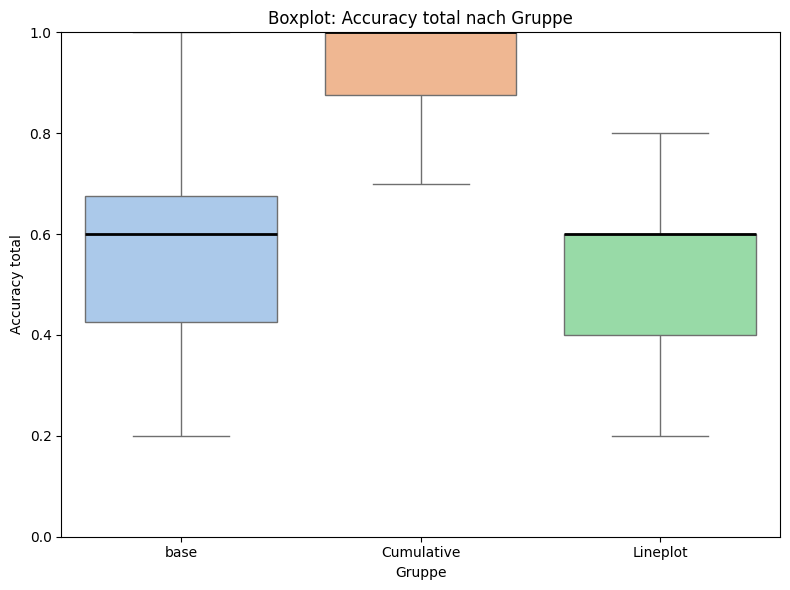

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=participants_accuracy, x='group', y='Accuracy total', hue='group', palette='pastel', legend=False, showfliers=False, medianprops={'color': 'black', 'linewidth': 2})
plt.title('Boxplot: Accuracy total nach Gruppe')
plt.xlabel('Gruppe')
plt.ylabel('Accuracy total')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### 5.1.6 Efficiency

In [42]:
# Hilfsmatrix erstellen
categories = {
    'Simple Value': ['t_q01_time', 't_q02_time'],
    'Comparison': ['t_q03_time', 't_q04_time', 't_q05_time'],
    'Pattern Recognition': ['t_q06_time', 't_q07_time', 't_q08_time'],
    'Bounded Inference': ['t_q09_time', 't_q10_time']
}

participants_efficiency = pd.DataFrame(index=df.index)

participants_efficiency['group'] = df['group']

for cat_name, question_cols in categories.items():
    participants_efficiency[cat_name] = df[question_cols].mean(axis=1)

participants_efficiency['Efficiency total'] = df[[f't_q{i:02d}_time' for i in range(1, 11)]].mean(axis=1)

participants_efficiency.head()

,group,Simple Value,Comparison,Pattern Recognition,Bounded Inference,Efficiency total
0,base,147.5,65.333333,46.666667,55.0,74.1
1,base,87.0,61.000000,28.333333,44.0,53.0
2,base,68.5,39.666667,20.666667,15.5,34.9
3,base,55.5,29.333333,25.000000,45.0,36.4
4,base,214.5,129.333333,39.000000,49.0,103.2


### 5.1.7 Test Normalverteilung

In [43]:
# Testen, ob Daten normalverteilt, um zu bestimmen ob ANOVA oder Kruskal-Wallis-Test sowie t-Test oder Mann-Whitney-U-Test
for group_name in ['base', 'Lineplot', 'Cumulative']:
    data = participants_efficiency.loc[participants_efficiency['group'] == group_name, 'Efficiency total']
    stat, p = shapiro(data)
    print(f"{group_name}: W = {stat:.3f}, p = {p:.4f}")

base: W = 0.941, p = 0.0959
Lineplot: W = 0.843, p = 0.0004
Cumulative: W = 0.757, p = 0.0000


### 5.1.8 Kruskal-Wallis-Test

In [44]:
# Lineplot und Cumulative sind nicht normalverteilt -> Kruskal-Wallis-Test auf Efficiency total
base_efficiency = participants_efficiency.loc[participants_efficiency['group'] == 'base', 'Efficiency total']
lineplot_efficiency = participants_efficiency.loc[participants_efficiency['group'] == 'Lineplot', 'Efficiency total']
cumulative_efficiency = participants_efficiency.loc[participants_efficiency['group'] == 'Cumulative', 'Efficiency total']

# Kruskal–Wallis-Test
h_stat, p_kruskal = kruskal(base_efficiency, lineplot_efficiency, cumulative_efficiency)

print(f"Kruskal–Wallis H-Statistik: {h_stat:.3f}")
print(f"p-Wert: {p_kruskal:.4f}")


Kruskal–Wallis H-Statistik: 23.915
p-Wert: 0.0000


### 5.1.9 Directional Mann-Whitney Test

In [45]:
# 1. cumulative < base
stat_cb, p_cb = mannwhitneyu(cumulative_efficiency, base_efficiency, alternative='less')

# 2. cumulative < lineplot
stat_cl, p_cl = mannwhitneyu(cumulative_efficiency, lineplot_efficiency, alternative='less')

# Ergebnisse anzeigen
print(f"Cumulative < Base: U = {stat_cb}, p = {p_cb:.4f}")
print(f"Cumulative < Lineplot: U = {stat_cl}, p = {p_cl:.4f}")

Cumulative < Base: U = 178.0, p = 0.0000
Cumulative < Lineplot: U = 185.5, p = 0.0000


In [46]:
# 1. cumulative < base
n_cum = len(cumulative_efficiency)
n_base = len(base_efficiency)
u_mean_cb = n_cum * n_base / 2
u_std_cb = np.sqrt(n_cum * n_base * (n_cum + n_base + 1) / 12)
z_cb = (stat_cb - u_mean_cb) / u_std_cb
r_cb = abs(z_cb) / np.sqrt(n_cum + n_base)

# 2. cumulative < lineplot
n_line = len(lineplot_efficiency)
u_mean_cl = n_cum * n_line / 2
u_std_cl = np.sqrt(n_cum * n_line * (n_cum + n_line + 1) / 12)
z_cl = (stat_cl - u_mean_cl) / u_std_cl
r_cl = abs(z_cl) / np.sqrt(n_cum + n_line)

# Effektstärken ausgeben
print(f"Effektstärke r (Cumulative < Base, Efficiency): {r_cb:.3f}")
print(f"Effektstärke r (Cumulative < Lineplot, Efficiency): {r_cl:.3f}")

Effektstärke r (Cumulative < Base, Efficiency): 0.540
Effektstärke r (Cumulative < Lineplot, Efficiency): 0.527


### 5.1.10 Verteilungsplots

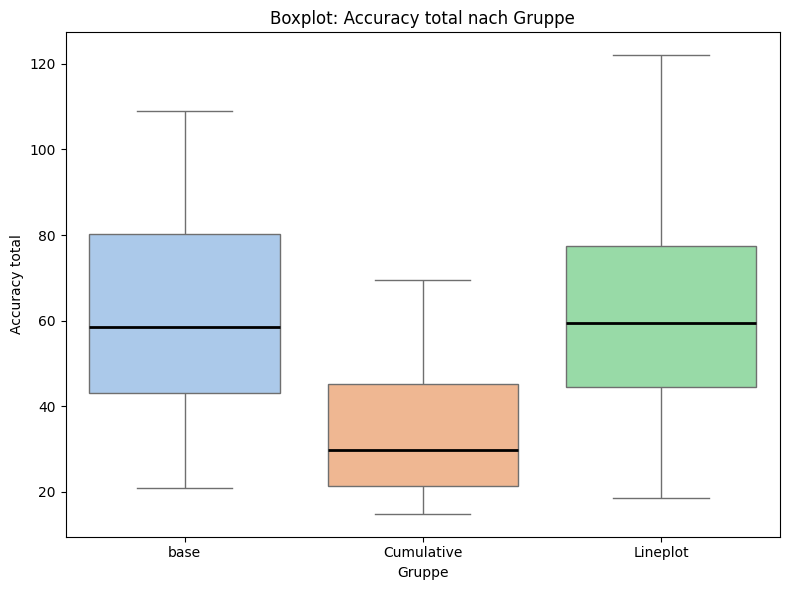

In [47]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=participants_efficiency, x='group', y='Efficiency total', hue='group', palette='pastel', legend=False, showfliers=False, medianprops={'color': 'black', 'linewidth': 2})
plt.title('Boxplot: Accuracy total nach Gruppe')
plt.xlabel('Gruppe')
plt.ylabel('Accuracy total')

plt.tight_layout()
plt.show()

## 5.2 Hypothesis 1

In [48]:
# H2: lineplot_accuracy > base_accuracy
stat_lb, p_lb = mannwhitneyu(
    participants_accuracy.loc[participants_accuracy['group'] == 'Lineplot', 'Accuracy total'],
    participants_accuracy.loc[participants_accuracy['group'] == 'base', 'Accuracy total'],
    alternative='greater'
)

print(f"Lineplot > Base (Accuracy): U = {stat_lb}, p = {p_lb:.4f}")

Lineplot > Base (Accuracy): U = 450.5, p = 0.5000


In [49]:
group1 = participants_accuracy.loc[participants_accuracy['group'] == 'Lineplot', 'Accuracy total']
group2 = participants_accuracy.loc[participants_accuracy['group'] == 'base', 'Accuracy total']

# Mann–Whitney U-Test (zweiseitig, nur um z zu berechnen)
u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

# z-Wert berechnen
n1 = len(group1)
n2 = len(group2)
u_mean = n1 * n2 / 2
u_std = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (u_stat - u_mean) / u_std

# Effektstärke r berechnen
r = abs(z) / np.sqrt(n1 + n2)

print(f"Effektstärke r: {r:.3f}")

Effektstärke r: 0.001


/var/folders/82/kbvzpwhd50j91vkgzn8h3gnr0000gn/T/ipykernel_60583/2179902827.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


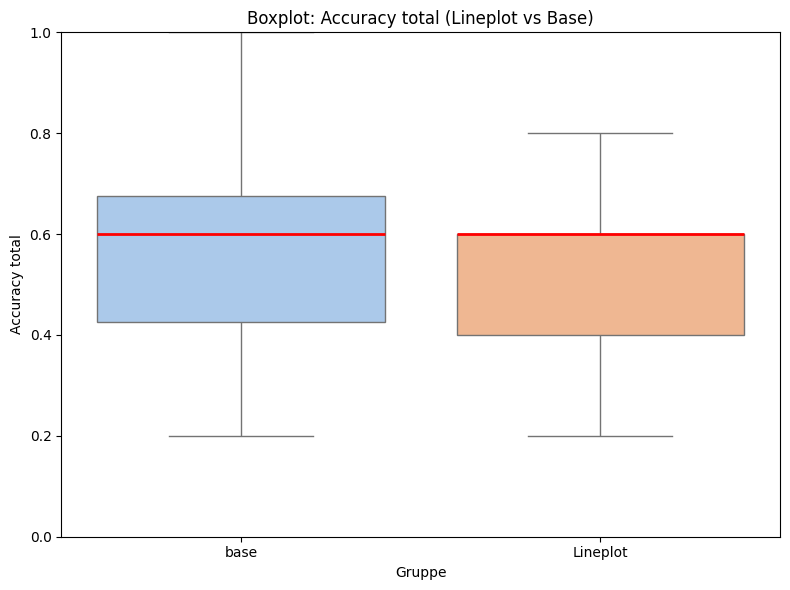

In [50]:
participants_accuracy_subset = participants_accuracy[
    participants_accuracy['group'].isin(['Lineplot', 'base'])
]

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=participants_accuracy_subset,
    x='group',
    y='Accuracy total',
    palette='pastel',
    showfliers=False,
    medianprops={'color': 'red', 'linewidth': 2}
)
plt.title('Boxplot: Accuracy total (Lineplot vs Base)')
plt.xlabel('Gruppe')
plt.ylabel('Accuracy total')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## 5.3 Hypothesis 3

### 5.3.1 Self-reported Confidence

In [51]:
# Hilfsmatrix erstellen
categories = {
    'Simple Value': ['t_q01_conf', 't_q02_conf'],
    'Comparison': ['t_q03_conf', 't_q04_conf', 't_q05_conf'],
    'Pattern Recognition': ['t_q06_conf', 't_q07_conf', 't_q08_conf'],
    'Bounded Inference': ['t_q09_conf', 't_q10_conf']
}

participants_confidence = pd.DataFrame(index=df.index)

participants_confidence['group'] = df['group']

for cat_name, question_cols in categories.items():
    participants_confidence[cat_name] = df[question_cols].mean(axis=1)

participants_confidence['confidence total'] = df[[f't_q{i:02d}_conf' for i in range(1, 11)]].mean(axis=1)

participants_confidence.head()

,group,Simple Value,Comparison,Pattern Recognition,Bounded Inference,confidence total
0,base,2.5,2.0,2.0,2.5,2.2
1,base,5.0,6.0,6.0,5.0,5.6
2,base,3.5,3.333333,3.333333,4.0,3.5
3,base,5.5,5.0,5.333333,6.5,5.5
4,base,5.5,4.0,3.666667,4.5,4.3


In [52]:
# Confidence ist nur ordinal -> Kruskal-Wallis-Test
base_confidence = participants_confidence.loc[participants_confidence['group'] == 'base', 'confidence total']
lineplot_confidence = participants_confidence.loc[participants_confidence['group'] == 'Lineplot', 'confidence total']
cumulative_confidence = participants_confidence.loc[participants_confidence['group'] == 'Cumulative', 'confidence total']

# Kruskal–Wallis-Test
h_stat, p_kruskal = kruskal(base_confidence, lineplot_confidence, cumulative_confidence)

print(f"Kruskal–Wallis H-Statistik: {h_stat:.3f}")
print(f"p-Wert: {p_kruskal:.4f}")

Kruskal–Wallis H-Statistik: 16.234
p-Wert: 0.0003


In [53]:
# Konvertieren auf float
cumulative_confidence = cumulative_confidence.astype(float)
base_confidence = base_confidence.astype(float)
lineplot_confidence = lineplot_confidence.astype(float)

# 1. cumulative > base
stat_cb, p_cb = mannwhitneyu(cumulative_confidence, base_confidence, alternative='greater')

# 2. cumulative > lineplot
stat_cl, p_cl = mannwhitneyu(cumulative_confidence, lineplot_confidence, alternative='greater')

# Ergebnisse anzeigen
print(f"Cumulative > Base: U = {stat_cb}, p = {p_cb:.4f}")
print(f"Cumulative > Lineplot: U = {stat_cl}, p = {p_cl:.4f}")

Cumulative > Base: U = 701.0, p = 0.0009
Cumulative > Lineplot: U = 743.5, p = 0.0001


In [54]:
n_cum = len(cumulative_confidence)
n_base = len(base_confidence)
n_line = len(lineplot_confidence)

# 1. cumulative > base
u_mean_cb = n_cum * n_base / 2
u_std_cb = np.sqrt(n_cum * n_base * (n_cum + n_base + 1) / 12)
z_cb = (stat_cb - u_mean_cb) / u_std_cb
r_cb = abs(z_cb) / np.sqrt(n_cum + n_base)

# 2. cumulative > lineplot
u_mean_cl = n_cum * n_line / 2
u_std_cl = np.sqrt(n_cum * n_line * (n_cum + n_line + 1) / 12)
z_cl = (stat_cl - u_mean_cl) / u_std_cl
r_cl = abs(z_cl) / np.sqrt(n_cum + n_line)

# Effektstärken ausgeben
print(f"Effektstärke r (Cumulative > Base, Efficiency): {r_cb:.3f}")
print(f"Effektstärke r (Cumulative > Lineplot, Efficiency): {r_cl:.3f}")

Effektstärke r (Cumulative > Base, Efficiency): 0.395
Effektstärke r (Cumulative > Lineplot, Efficiency): 0.471


### 5.3.2 Hint usage

In [55]:
# Hilfsmatrix erstellen
categories = {
    'Simple Value': ['t_q01_hint', 't_q02_hint'],
    'Comparison': ['t_q03_hint', 't_q04_hint', 't_q05_hint'],
    'Pattern Recognition': ['t_q06_hint', 't_q07_hint', 't_q08_hint'],
    'Bounded Inference': ['t_q09_hint', 't_q10_hint']
}

participants_hint_usage = pd.DataFrame(index=df.index)

participants_hint_usage['group'] = df['group']

for cat_name, question_cols in categories.items():
    participants_hint_usage[cat_name] = df[question_cols].mean(axis=1)

participants_hint_usage['hint_usage total'] = df[[f't_q{i:02d}_hint' for i in range(1, 11)]].mean(axis=1)

participants_hint_usage.head()

,group,Simple Value,Comparison,Pattern Recognition,Bounded Inference,hint_usage total
0,base,0.0,0.000000,0.0,0.0,0.0
1,base,0.0,0.000000,0.0,0.0,0.0
2,base,0.0,0.000000,0.0,0.0,0.0
3,base,0.0,0.000000,0.0,0.0,0.0
4,base,0.5,0.333333,0.0,0.0,0.2


### 5.3.2.1 Test Normalverteilung zur Bestimmung ANOVA oder Kruskal-Wallis-Test sowie t-Test oder Mann-Whitney-U-Test

In [56]:
# Testen, ob Daten normalverteilt, um zu bestimmen ob ANOVA oder Kruskal-Wallis-Test sowie t-Test oder Mann-Whitney-U-Test
for group_name in ['base', 'Lineplot', 'Cumulative']:
    data = participants_hint_usage.loc[participants_hint_usage['group'] == group_name, 'hint_usage total']
    stat, p = shapiro(data)
    print(f"{group_name}: W = {stat:.3f}, p = {p:.4f}")

base: W = 0.632, p = 0.0000
Lineplot: W = 0.657, p = 0.0000
Cumulative: W = 0.348, p = 0.0000


### 5.3.2.2 Kruskal-Wallis-Test

In [57]:
# Alle Gruppen sind nicht normalverteilt -> Kruskal-Wallis-Test auf hint_usage total
base_hint_usage = participants_hint_usage.loc[participants_hint_usage['group'] == 'base', 'hint_usage total']
lineplot_hint_usage = participants_hint_usage.loc[participants_hint_usage['group'] == 'Lineplot', 'hint_usage total']
cumulative_hint_usage = participants_hint_usage.loc[participants_hint_usage['group'] == 'Cumulative', 'hint_usage total']

# Kruskal–Wallis-Test
h_stat, p_kruskal = kruskal(base_hint_usage, lineplot_hint_usage, cumulative_hint_usage)

print(f"Kruskal–Wallis H-Statistik: {h_stat:.3f}")
print(f"p-Wert: {p_kruskal:.4f}")

Kruskal–Wallis H-Statistik: 3.342
p-Wert: 0.1881


In [58]:
# 1. cumulative < base
stat_cb, p_cb = mannwhitneyu(cumulative_hint_usage, base_hint_usage, alternative='less')

# 2. cumulative < lineplot
stat_cl, p_cl = mannwhitneyu(cumulative_hint_usage, lineplot_hint_usage, alternative='less')

# Ergebnisse anzeigen
print(f"Cumulative < Base: U = {stat_cb}, p = {p_cb:.4f}")
print(f"Cumulative < Lineplot: U = {stat_cl}, p = {p_cl:.4f}")

Cumulative < Base: U = 411.5, p = 0.0949
Cumulative < Lineplot: U = 381.5, p = 0.0358


In [59]:
n_cum = len(cumulative_hint_usage)
n_base = len(base_hint_usage)
n_line = len(lineplot_hint_usage)

# 1. cumulative < base
u_mean_cb = n_cum * n_base / 2
u_std_cb = np.sqrt(n_cum * n_base * (n_cum + n_base + 1) / 12)
z_cb = (stat_cb - u_mean_cb) / u_std_cb
r_cb = abs(z_cb) / np.sqrt(n_cum + n_base)

# 2. cumulative < lineplot
u_mean_cl = n_cum * n_line / 2
u_std_cl = np.sqrt(n_cum * n_line * (n_cum + n_line + 1) / 12)
z_cl = (stat_cl - u_mean_cl) / u_std_cl
r_cl = abs(z_cl) / np.sqrt(n_cum + n_line)

print(f"Effektstärke r (Cumulative < Base, Hint Usage): {r_cb:.3f}")
print(f"Effektstärke r (Cumulative < Lineplot, Hint Usage): {r_cl:.3f}")

Effektstärke r (Cumulative < Base, Hint Usage): 0.123
Effektstärke r (Cumulative < Lineplot, Hint Usage): 0.176


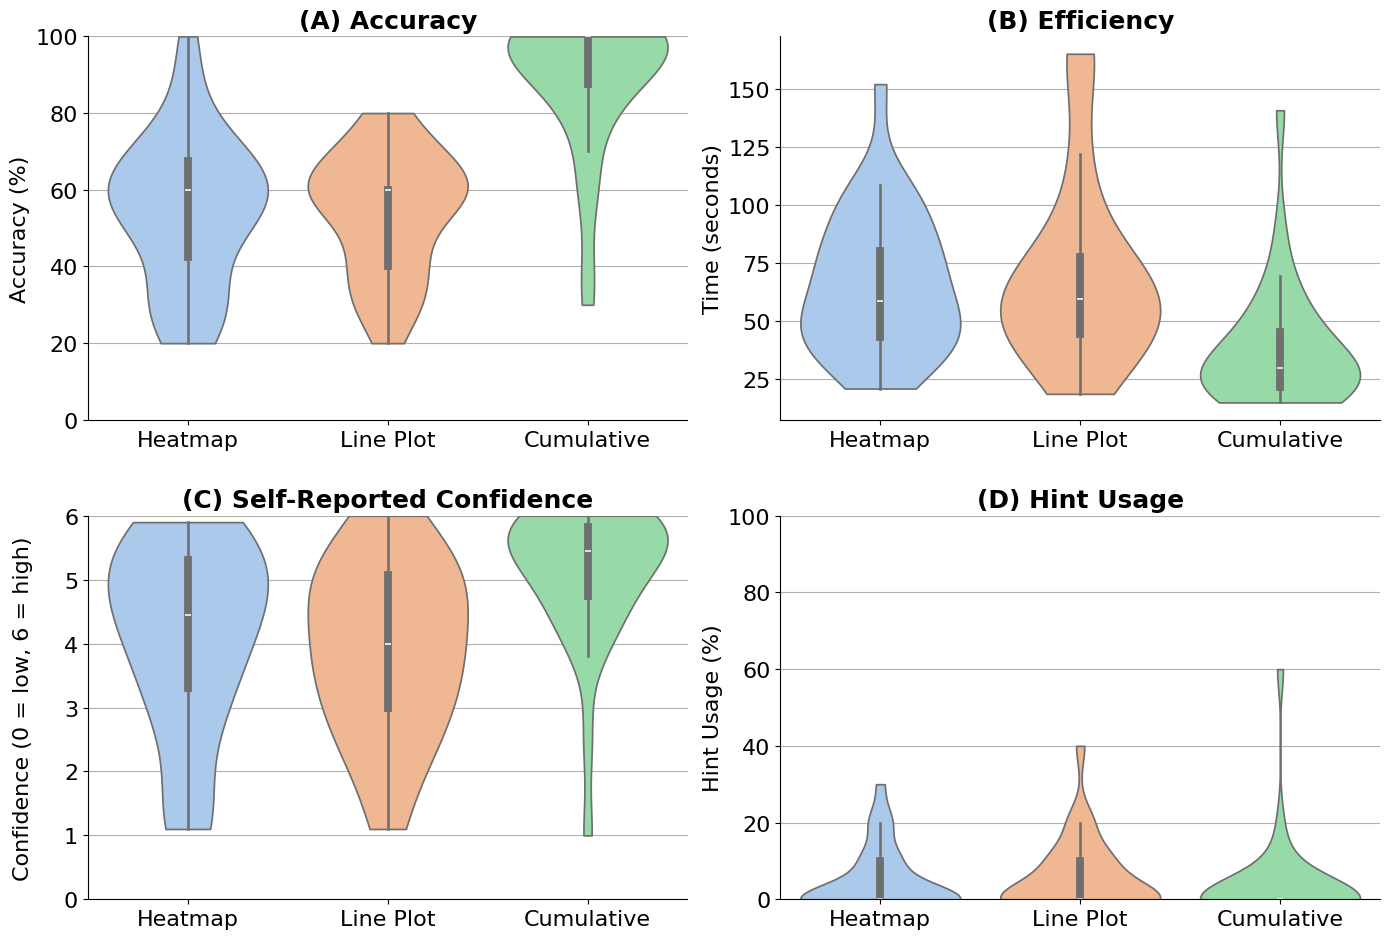

In [60]:
plot_accuracy = participants_accuracy.copy()
plot_efficiency = participants_efficiency.copy()
plot_confidence = participants_confidence.copy()
plot_hint_usage = participants_hint_usage.copy()

plot_accuracy.iloc[:, 1:6] *= 100
plot_hint_usage.iloc[:, 1:6] *= 100
plot_confidence.iloc[:, 1:6] -= 1

desired_order = ['base', 'Lineplot', 'Cumulative']
for dframe in [plot_accuracy, plot_efficiency, plot_confidence, plot_hint_usage]:
    dframe['group'] = pd.Categorical(dframe['group'], categories=desired_order, ordered=True)

for dframe in [plot_accuracy, plot_efficiency, plot_confidence, plot_hint_usage]:
    dframe['group'] = dframe['group'].cat.rename_categories({'base': 'Heatmap', 'Lineplot': 'Line Plot'})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

common_plot_settings = {"palette": "pastel", "inner": "box", "cut": 0, 'hue':'group', 'legend':False}

# Accuracy
sns.violinplot(data=plot_accuracy, x='group', y='Accuracy total', ax=axes[0, 0], **common_plot_settings)
axes[0, 0].set_title('(A) Accuracy', fontsize=18, fontweight='semibold')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=16)

# Efficiency
sns.violinplot(data=plot_efficiency, x='group', y='Efficiency total', ax=axes[0, 1], **common_plot_settings)
axes[0, 1].set_title('(B) Efficiency', fontsize=18, fontweight='semibold')
axes[0, 1].set_ylabel('Time (seconds)', fontsize=16)

# Confidence
sns.violinplot(data=plot_confidence, x='group', y='confidence total', ax=axes[1, 0], **common_plot_settings)
axes[1, 0].set_title('(C) Self-Reported Confidence', fontsize=18, fontweight='semibold')
axes[1, 0].set_ylim(0, 6)
axes[1, 0].set_ylabel("Confidence (0 = low, 6 = high)", fontsize=16, labelpad=22)

# Hint Usage
sns.violinplot(data=plot_hint_usage, x='group', y='hint_usage total', ax=axes[1, 1], **common_plot_settings)
axes[1, 1].set_title('(D) Hint Usage', fontsize=18, fontweight='semibold')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].set_ylabel('Hint Usage (%)', fontsize=16)

# Clean up and format axes
for ax in axes.flatten():
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.25)
plt.savefig("/Users/maximilianveitl/Downloads/violinplot.png", dpi=300, bbox_inches='tight')


# 6. Exploratory Analysis

## 6.1 Performance across task categories

In [61]:
plot_composite = pd.DataFrame(index=df.index)
plot_composite['group'] = df['group']

categories = {
    'Simple Value': ['Q1', 'Q2'],
    'Comparison': ['Q3', 'Q4', 'Q5'],
    'Pattern Recognition': ['Q6', 'Q7', 'Q8'],
    'Bounded Inference': ['Q9', 'Q10']
}

for cat_name, question_cols in categories.items():
    plot_composite[cat_name] = df_cscore[question_cols].mean(axis=1)

plot_composite['Composite total'] = df_cscore[[f'Q{i}' for i in range(1, 11)]].mean(axis=1)

plot_composite['group'] = pd.Categorical(plot_composite['group'],categories=desired_order,ordered=True)
plot_composite['group'] = plot_composite['group'].cat.rename_categories({'base': 'Heatmap', 'Lineplot': 'Line Plot'})

plot_composite.head()

,group,Simple Value,Comparison,Pattern Recognition,Bounded Inference,Composite total
0,Heatmap,25.416667,55.777778,58.888889,65.833333,52.650000
1,Heatmap,85.500000,56.500000,61.944444,67.666667,66.166667
2,Heatmap,38.583333,43.388889,79.888889,72.416667,59.183333
3,Heatmap,90.750000,45.111111,79.166667,92.500000,73.933333
4,Heatmap,10.000000,38.611111,93.500000,91.833333,60.000000


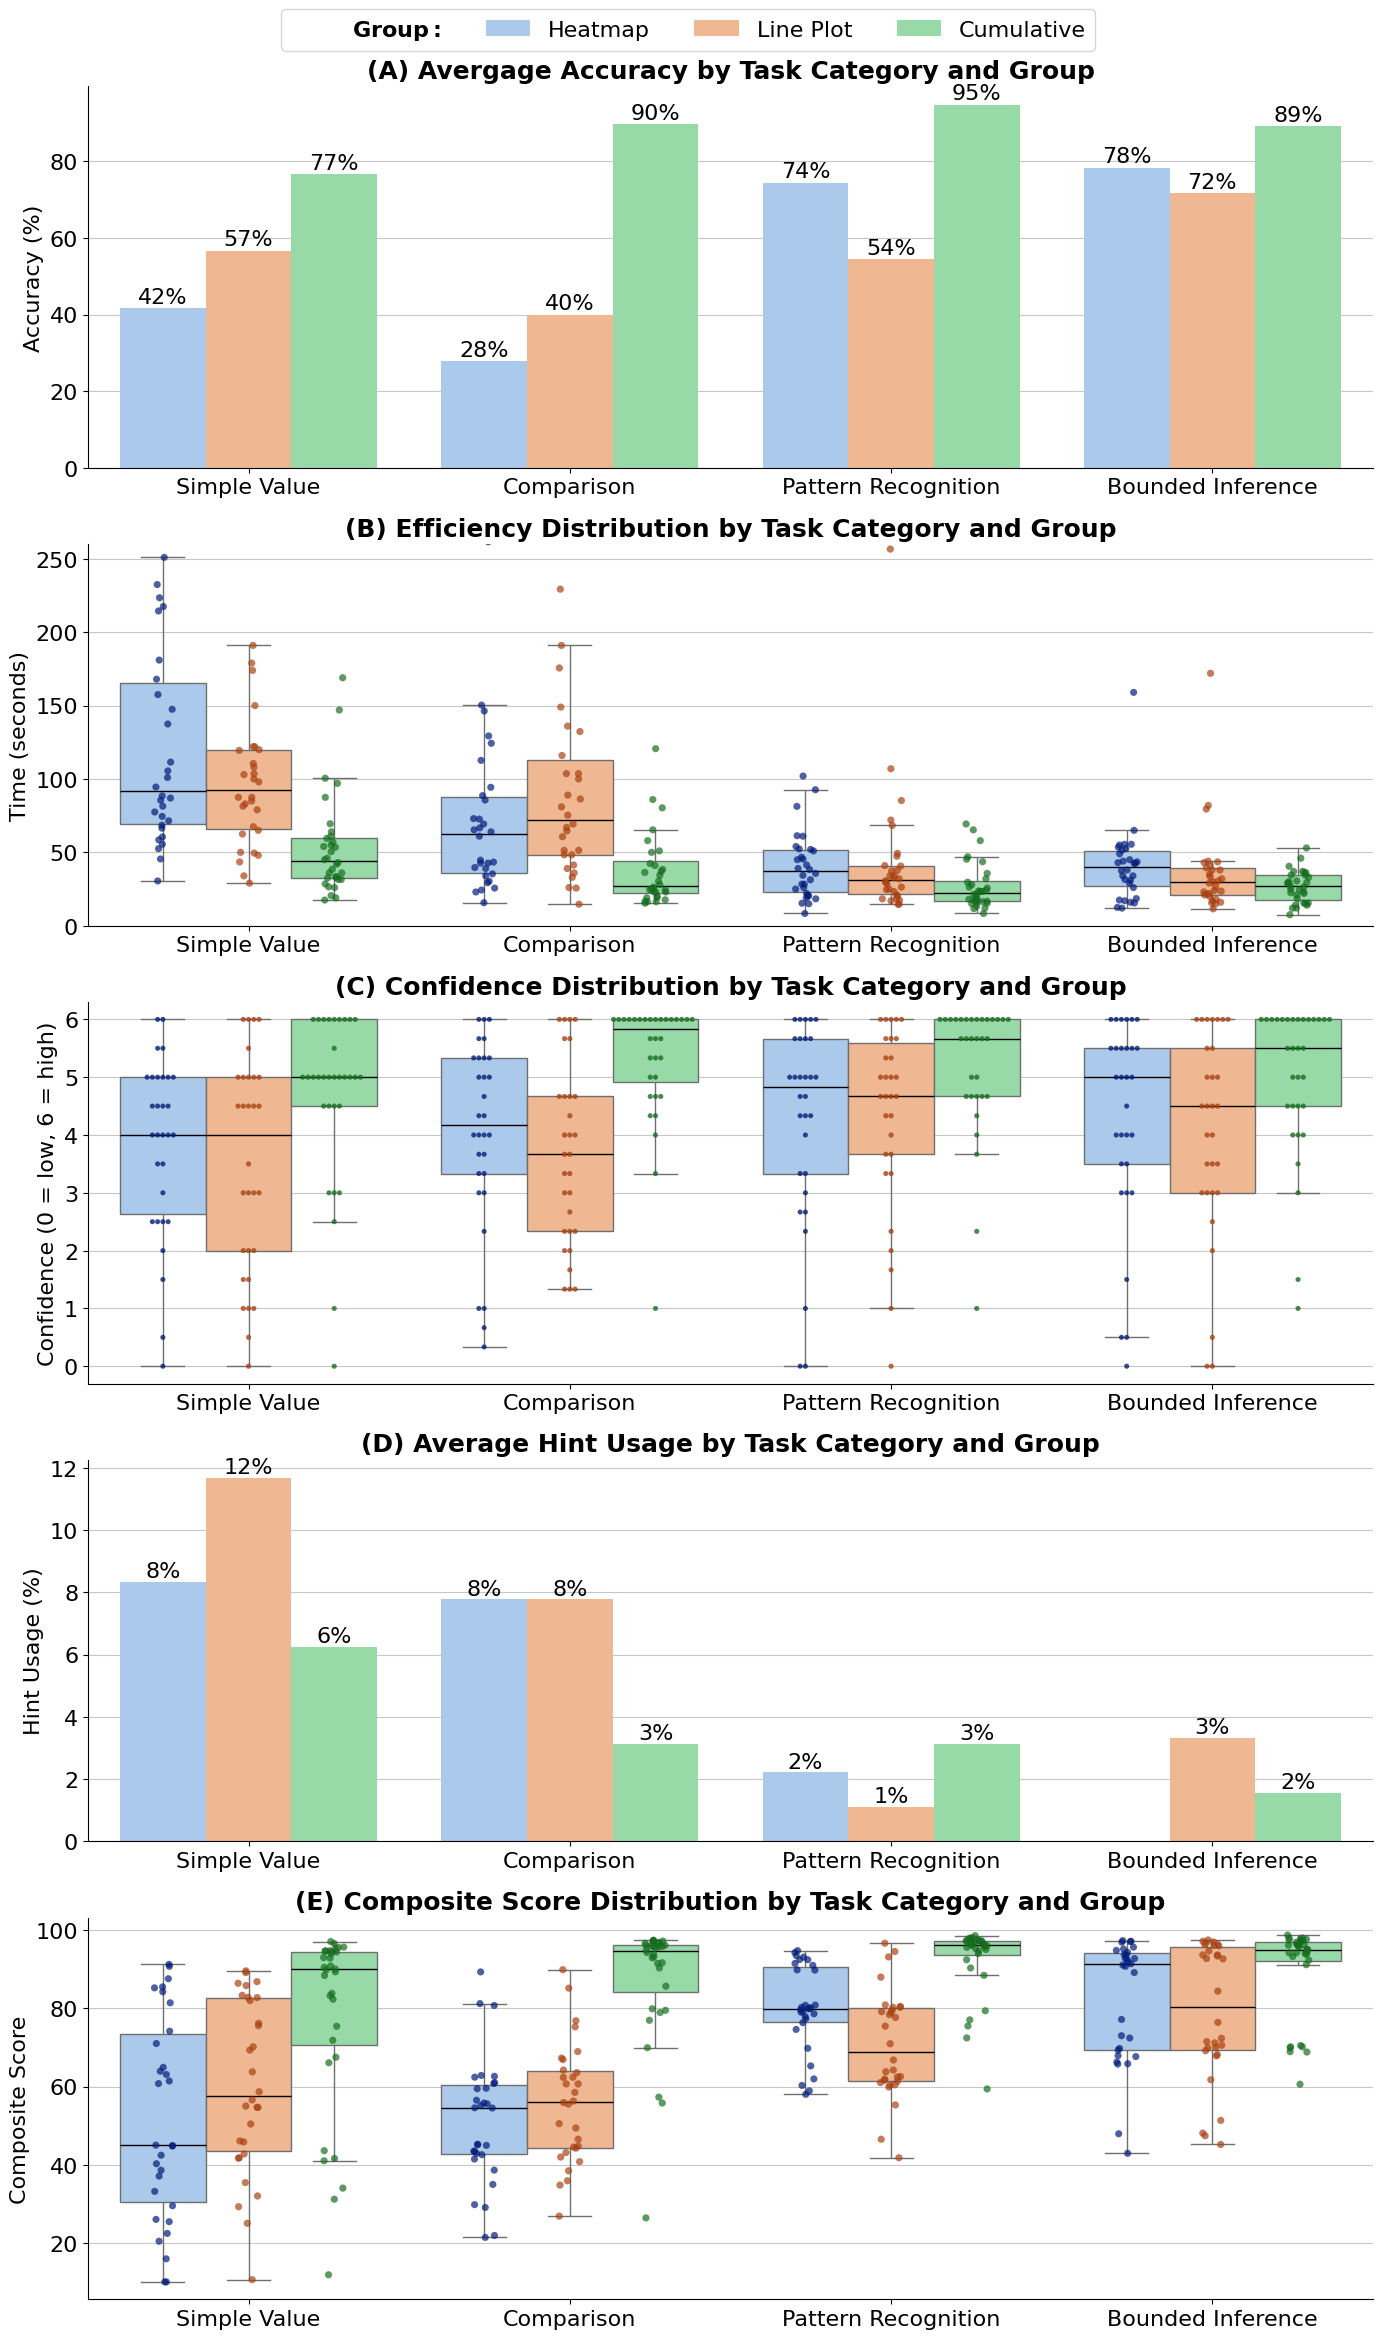

In [62]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 23))

plot_accuracy_melted = plot_accuracy.melt(id_vars='group', value_vars=['Simple Value', 'Comparison', 'Pattern Recognition', 'Bounded Inference'], var_name='Task Category', value_name='Accuracy')
plot_efficiency_melted = plot_efficiency.melt(id_vars='group', value_vars=['Simple Value', 'Comparison', 'Pattern Recognition', 'Bounded Inference'], var_name='Task Category', value_name='Efficiency')
plot_confidence_melted = plot_confidence.melt(id_vars='group', value_vars=['Simple Value', 'Comparison', 'Pattern Recognition', 'Bounded Inference'], var_name='Task Category', value_name='confidence')
plot_hint_usage_melted = plot_hint_usage.melt(id_vars='group', value_vars=['Simple Value', 'Comparison', 'Pattern Recognition', 'Bounded Inference'], var_name='Task Category', value_name='Hint Usage')
plot_composite_melted = plot_composite.melt(id_vars='group', value_vars=['Simple Value', 'Comparison', 'Pattern Recognition', 'Bounded Inference'], var_name='Task Category', value_name='composite')


# Accuracy Barplot
sns.barplot(
    data=plot_accuracy_melted,
    x='Task Category',
    y='Accuracy',
    hue='group',
    errorbar=None,
    palette='pastel',
    ax=axes[0]
)
ax = axes[0]

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.3,
                f'{height:.0f}%',
                ha='center',
                va='bottom',
                fontsize=16
            )
axes[0].set_title('(A) Avergage Accuracy by Task Category and Group', fontsize=18, fontweight='semibold')
axes[0].grid(axis='y', linestyle='-', alpha=0.7)
axes[0].set_ylabel('Accuracy (%)', fontsize=16)
axes[0].set_xlabel('')
axes[0].get_legend().remove()

from matplotlib.patches import Patch

# Originale Legendeneinträge holen
handles, labels = axes[0].get_legend_handles_labels()

# Dummy-Handle für "Group:"
dummy = Patch(facecolor='none', edgecolor='none')

# "Group:" fett setzen (funktioniert in PDF/LaTeX-kompatiblen Umgebungen als Workaround)
handles = [dummy] + handles
labels = [r'$\bf{Group:}$'] + labels

# Legende oben rechts platzieren
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=4,
    fontsize=16,
    frameon=True
)


#Plot efficiency
sns.boxplot(
    data=plot_efficiency_melted,
    x='Task Category',
    y='Efficiency',
    hue='group',
    palette='pastel',
    dodge=True,
    fliersize=0,
    medianprops={'linewidth': 1, 'color': 'black'},
    ax=axes[1]
)
sns.stripplot(
    data=plot_efficiency_melted,
    x='Task Category',
    y='Efficiency',
    hue='group',
    dodge=True,
    palette='dark',
    alpha=0.7,
    jitter=True,
    linewidth=.1,
    marker='o',
    ax=axes[1]
)
axes[1].set_title('(B) Efficiency Distribution by Task Category and Group', fontsize=18, fontweight='semibold')
axes[1].set_ylim(0, 260)
axes[1].set_ylabel('Time (seconds)', fontsize=16)
axes[1].grid(axis='y', linestyle='-', alpha=0.7)
axes[1].set_xlabel('')
axes[1].get_legend().remove()

# Plot: Confidence
sns.boxplot(
    data=plot_confidence_melted,
    x='Task Category',
    y='confidence',
    hue='group',
    palette='pastel',
    dodge=True,
    fliersize=0,
    medianprops={'linewidth': 1, 'color': 'black'},
    ax=axes[2]
)

sns.swarmplot(
    data=plot_confidence_melted,
    x='Task Category',
    y='confidence',
    hue='group',
    dodge=True,
    palette='dark',
    alpha=0.8,
    size=3.5,
    linewidth=0.1,
    ax=axes[2]
)
axes[2].set_title('(C) Confidence Distribution by Task Category and Group', fontsize=18, fontweight='semibold')
axes[2].grid(axis='y', linestyle='-', alpha=0.7)
axes[2].set_ylabel("Confidence (0 = low, 6 = high)", fontsize=16)
axes[2].set_xlabel('')
axes[2].get_legend().remove()

# Plot: Hint Usage
ax = sns.barplot(
    data=plot_hint_usage_melted,
    x='Task Category',
    y='Hint Usage',
    hue='group',
    errorbar=None,
    palette='pastel',
    ax=axes[3]
)
ax = axes[3]
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.018,
                f'{height:.0f}%',
                ha='center',
                va='bottom',
                fontsize=16
            )
axes[3].set_title('(D) Average Hint Usage by Task Category and Group', fontsize=18, fontweight='semibold')
axes[3].grid(axis='y', linestyle='-', alpha=0.7)
axes[3].set_ylabel('Hint Usage (%)', fontsize=16)
axes[3].set_xlabel('')
axes[3].get_legend().remove()

# Plot: Composite Score
sns.boxplot(
    data=plot_composite_melted,
    x='Task Category',
    y='composite',
    hue='group',
    palette='pastel',
    dodge=True,
    fliersize=0,
    medianprops={'linewidth': 1, 'color': 'black'},
    ax=axes[4]
)

sns.stripplot(
    data=plot_composite_melted,
    x='Task Category',
    y='composite',
    hue='group',
    dodge=True,
    palette='dark',
    alpha=0.7,
    jitter=True,
    linewidth=.1,
    marker='o',
    ax=axes[4]
)
axes[4].set_title('(E) Composite Score Distribution by Task Category and Group', fontsize=18, fontweight='semibold')
axes[4].grid(axis='y', linestyle='-', alpha=0.7)
axes[4].set_ylabel('Composite Score', fontsize=16)
axes[4].set_xlabel('')
axes[4].get_legend().remove()

for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
#plt.show()
plt.savefig("/Users/maximilianveitl/Downloads/task_comp.png", dpi=400, bbox_inches='tight')

#plt.savefig("/Users/maximilianveitl/Downloads/task_comparison.png", dpi=400, bbox_inches='tight')


## 6.2 Korrelationen

### 6.2.1 Korrelationen Participant Level

In [63]:
df_corr_help = pd.DataFrame(index=df.index, columns=['prolific_id', 'group', 'accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU'])
df_corr_help['prolific_id'] = df['prolific_id']
df_corr_help['group'] = df['group']
df_corr_help['accuracy'] = (df['t_q01_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q02_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q03_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q04_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q05_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q06_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q07_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q08_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q09_corr'].map({'incorrect': 0, 'correct': 1}) + df['t_q10_corr'].map({'incorrect': 0, 'correct': 1}))/10
df_corr_help['efficiency'] = (df['t_q01_time'] + df['t_q02_time'] + df['t_q03_time'] + df['t_q04_time'] + df['t_q05_time'] + df['t_q06_time'] + df['t_q07_time'] + df['t_q08_time'] + df['t_q09_time'] + df['t_q10_time'])/10
df_corr_help['confidence'] = (df['t_q01_conf'] + df['t_q02_conf'] + df['t_q03_conf'] + df['t_q04_conf'] + df['t_q05_conf'] + df['t_q06_conf'] + df['t_q07_conf'] + df['t_q08_conf'] + df['t_q09_conf'] + df['t_q10_conf'])/10
df_corr_help['hint_usage'] = (df['t_q01_hint'] + df['t_q02_hint'] + df['t_q03_hint'] + df['t_q04_hint'] + df['t_q05_hint'] + df['t_q06_hint'] + df['t_q07_hint'] + df['t_q08_hint'] + df['t_q09_hint'] + df['t_q10_hint'])/10
df_corr_help['NASA_TLX'] = (df['nasa_1'] + df['nasa_2'] + df['nasa_3'] + df['nasa_4'] + df['nasa_5'] + df['nasa_6'])/6
df_corr_help['EOU'] = (df['use_1'] + df['use_2'] + df['use_3'] + df['use_4'] + df['use_5'] + df['use_6'])/6

df_corr_help.head()

,prolific_id,group,accuracy,efficiency,confidence,hint_usage,NASA_TLX,EOU
0,60b6245e249c0b94ab54dd2e,base,0.3,74.1,2.2,0.0,5.333333,6.500000
1,610e063896c52970e2c24bb5,base,0.5,53.0,5.6,0.0,4.0,4.500000
2,677fb45dee7e90f416b55aea,base,0.3,34.9,3.5,0.0,4.0,4.000000
3,5e9aff02f4a78b1a1fe7fc3c,base,0.6,36.4,5.5,0.0,4.0,4.500000
4,6667410306e83c646df6c338,base,0.6,103.2,4.3,0.2,4.5,2.833333


#### 6.2.1.1 Korrelationsmatrix Measures All Participants

In [64]:
df_corr_help[['accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU']].corr(method='spearman')

,accuracy,efficiency,confidence,hint_usage,NASA_TLX,EOU
accuracy,1.000000,-0.383140,0.518655,-0.363765,-0.595913,0.606516
efficiency,-0.383140,1.000000,-0.261800,0.220668,0.566474,-0.264996
confidence,0.518655,-0.261800,1.000000,-0.143627,-0.410233,0.528996
hint_usage,-0.363765,0.220668,-0.143627,1.000000,0.335623,-0.184256
NASA_TLX,-0.595913,0.566474,-0.410233,0.335623,1.000000,-0.493752
EOU,0.606516,-0.264996,0.528996,-0.184256,-0.493752,1.000000


<Axes: >

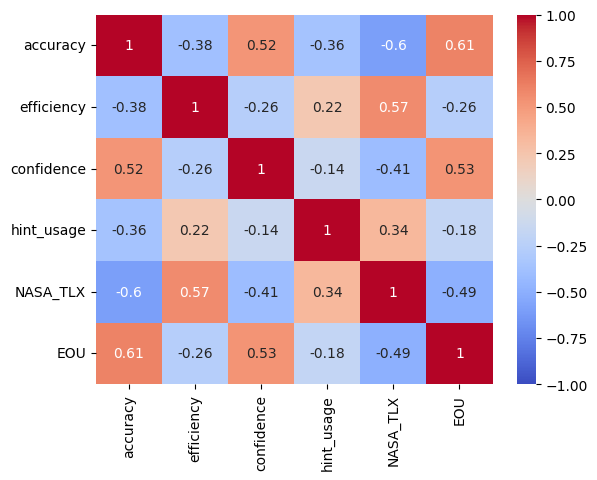

In [65]:
corr_matrix = df_corr_help[['accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU']].corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

#### 6.2.1.2 Korrelationsmatrix pro Teilnehmergruppe

In [66]:
grouped = df_corr_help.groupby(['group'])
for name, group in grouped:
    print(f"Group: {name}")
    corr_matrix = group[['accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU']].corr(method='spearman').round(2)
    print(corr_matrix)

Group: ('Cumulative',)
            accuracy  efficiency  confidence  hint_usage  NASA_TLX   EOU
accuracy        1.00       -0.39        0.36       -0.37     -0.66  0.30
efficiency     -0.39        1.00       -0.34        0.22      0.47 -0.09
confidence      0.36       -0.34        1.00       -0.25     -0.48  0.58
hint_usage     -0.37        0.22       -0.25        1.00      0.26 -0.05
NASA_TLX       -0.66        0.47       -0.48        0.26      1.00 -0.18
EOU             0.30       -0.09        0.58       -0.05     -0.18  1.00
Group: ('Lineplot',)
            accuracy  efficiency  confidence  hint_usage  NASA_TLX   EOU
accuracy        1.00        0.23        0.08       -0.41     -0.13  0.48
efficiency      0.23        1.00       -0.12       -0.17      0.33 -0.19
confidence      0.08       -0.12        1.00        0.18     -0.19  0.48
hint_usage     -0.41       -0.17        0.18        1.00      0.21 -0.09
NASA_TLX       -0.13        0.33       -0.19        0.21      1.00 -0.34
EOU    

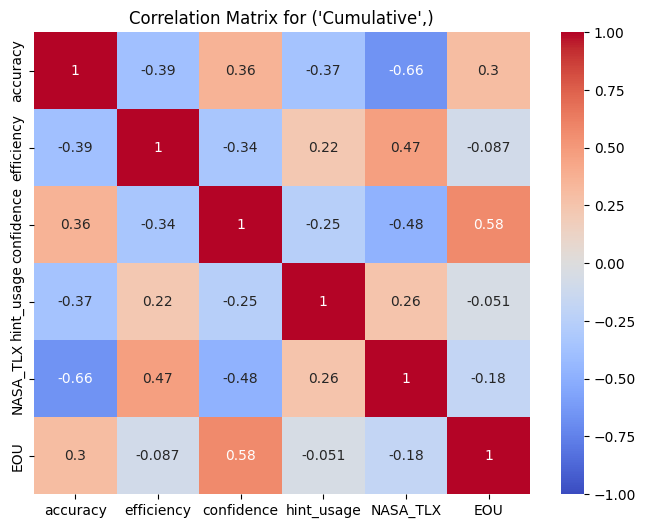

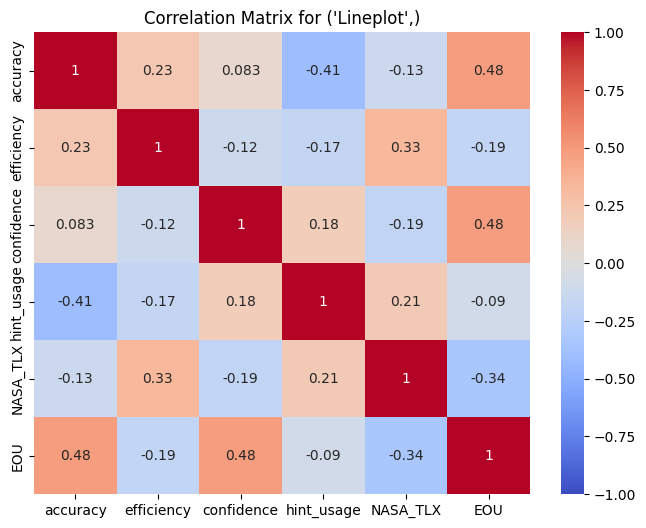

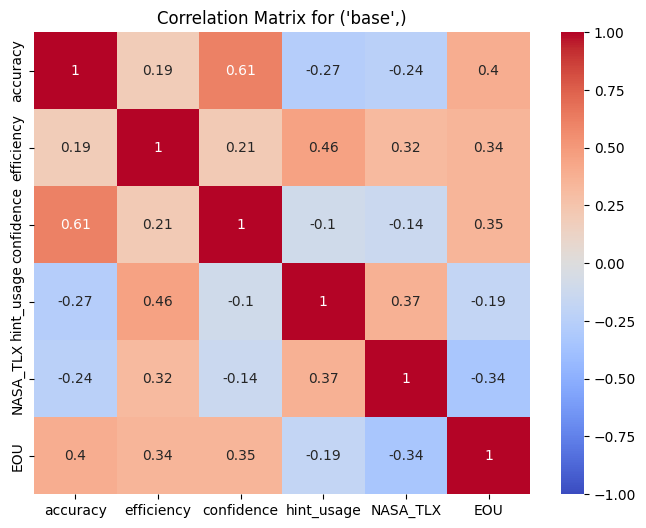

In [67]:
for name, group in grouped:
    corr_matrix = group[['accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU']].corr(method='spearman')
    plt.figure(figsize=(8, 6))
    plt.title(f'Correlation Matrix for {name}')
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()
    

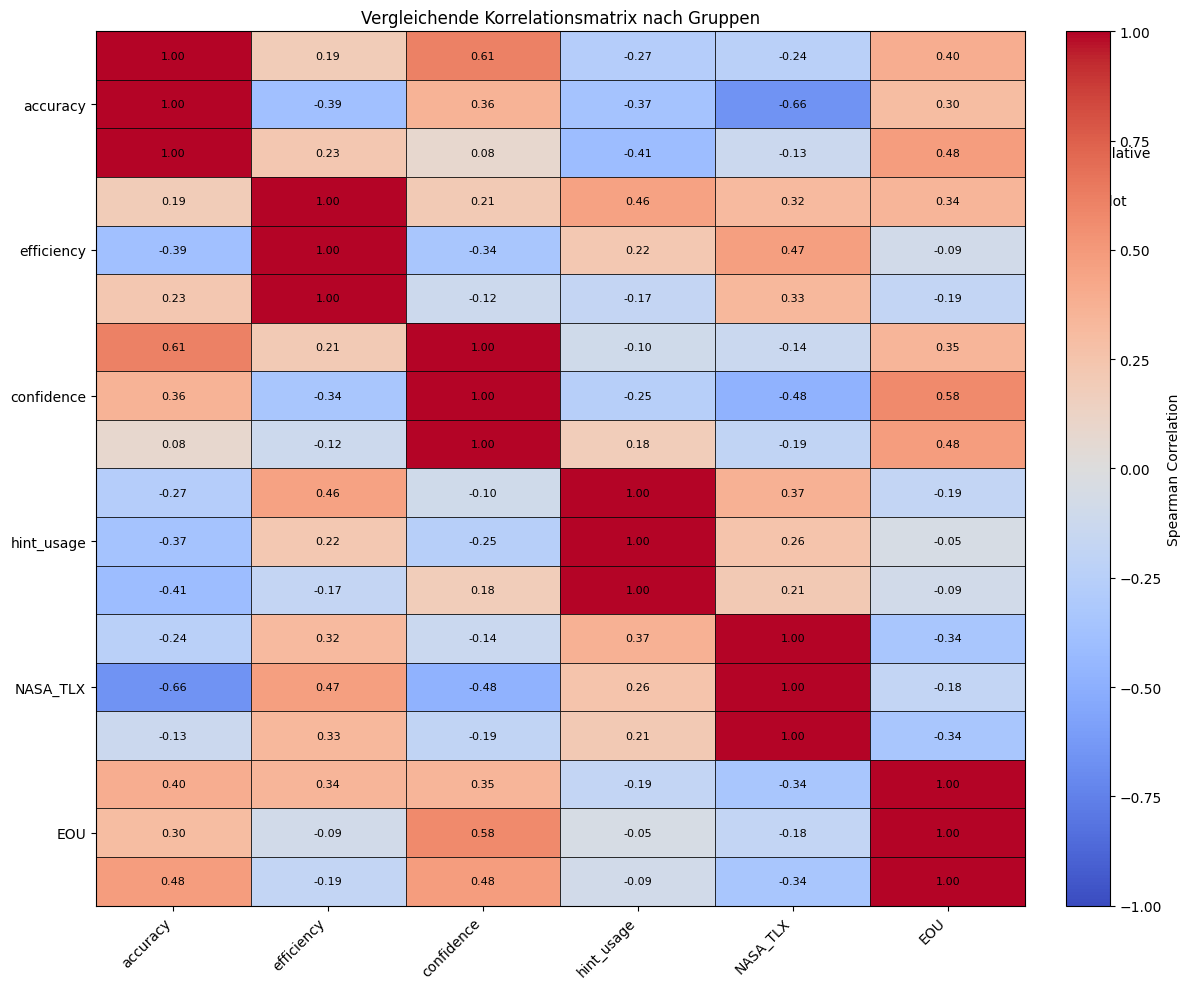

In [68]:
# Spalten für die Korrelationsmatrix
cols = ['accuracy', 'efficiency', 'confidence', 'hint_usage', 'NASA_TLX', 'EOU']
groups = df_corr_help['group'].unique()

# Korrelationsmatrizen pro Gruppe
corr_dict = {
    group: df_corr_help[df_corr_help['group'] == group][cols].corr(method='spearman')
    for group in groups
}

# Plot-Vorbereitung
fig, ax = plt.subplots(figsize=(12, 10))
n = len(cols)
grid = np.zeros((n, n, len(groups)))  # 3D-Array: Zeile, Spalte, Gruppe

# Fülle das grid mit den Korrelationswerten
for i, group in enumerate(groups):
    grid[:, :, i] = corr_dict[group].values

# Plot für jedes Kästchen mit geteilten Unterfeldern
for i in range(n):
    for j in range(n):
        for k, group in enumerate(groups):
            # Unterteilung des Quadrats in drei horizontale Drittel
            y0 = i
            x0 = j
            rect_height = 1 / len(groups)
            bottom = y0 + k * rect_height
            color = plt.cm.coolwarm((grid[i, j, k] + 1) / 2)  # Normierung von [-1,1] auf [0,1]
            ax.add_patch(plt.Rectangle(
                (x0, bottom), 1, rect_height,
                facecolor=color,
                edgecolor='black',
                linewidth=0.5
            ))
            ax.text(x0 + 0.5, bottom + rect_height / 2,
                    f'{grid[i, j, k]:.2f}',
                    ha='center', va='center',
                    fontsize=8, color='black')

# Achsenbeschriftungen
ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

# Legende: Farbskala
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1))
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Spearman Correlation')

# Gruppennamen als Legende für die Unterteilungen
for idx, group in enumerate(groups):
    ax.text(n + 0.3, idx * (1 / len(groups)) + 0.5, group, va='center')

ax.set_xlim(0, n)
ax.set_ylim(0, n)
ax.invert_yaxis()
plt.title('Vergleichende Korrelationsmatrix nach Gruppen')
plt.tight_layout()
plt.show()


## 6.3 Cognitive Load and EOU

In [69]:
df_corr_help

,prolific_id,group,accuracy,efficiency,confidence,hint_usage,NASA_TLX,EOU
0,60b6245e249c0b94ab54dd2e,base,0.3,74.1,2.2,0.0,5.333333,6.500000
1,610e063896c52970e2c24bb5,base,0.5,53.0,5.6,0.0,4.0,4.500000
2,677fb45dee7e90f416b55aea,base,0.3,34.9,3.5,0.0,4.0,4.000000
3,5e9aff02f4a78b1a1fe7fc3c,base,0.6,36.4,5.5,0.0,4.0,4.500000
4,6667410306e83c646df6c338,base,0.6,103.2,4.3,0.2,4.5,2.833333
...,...,...,...,...,...,...,...,...
87,5ae0c7d4e0feeb0001caff2b,Lineplot,0.3,165.4,4.0,0.0,4.833333,2.833333
88,67c6501f048f1eddb1c5b461,Lineplot,0.6,162.0,7.0,0.0,2.833333,6.333333
89,66bc038a785af1a7e20589eb,Lineplot,0.4,33.9,6.1,0.0,4.166667,4.833333
90,67360451448620a00803e7f5,Lineplot,0.5,75.3,6.2,0.2,4.166667,5.000000


In [70]:
# mapp group: base -> A, Lineplot -> B, Cumulative -> C
df_corr_help['group'] = df_corr_help['group'].map({'base': 'A', 'Lineplot': 'B', 'Cumulative': 'C'})

# sortiere nach group
df_corr_help = df_corr_help.sort_values(by=['group']).reset_index(drop=True)

# map group: A -> Heatmap, B -> Line Plot, C -> Cumulative
df_corr_help['group'] = df_corr_help['group'].map({'A': 'Heatmap', 'B': 'Line Plot', 'C': 'Cumulative'})

df_corr_help.head()

,prolific_id,group,accuracy,efficiency,confidence,hint_usage,NASA_TLX,EOU
0,60b6245e249c0b94ab54dd2e,Heatmap,0.3,74.1,2.2,0.0,5.333333,6.500000
1,6721dade50527833da0fd16d,Heatmap,0.6,46.2,5.9,0.0,5.0,4.666667
2,67c112fe8ac49aa620b3fcb1,Heatmap,0.4,79.1,3.9,0.3,7.0,2.666667
3,5c351b21d4ae620001d3ee01,Heatmap,0.2,52.2,2.3,0.1,4.666667,5.000000
4,6463d2c2867e932e835448a9,Heatmap,0.7,74.4,6.4,0.1,4.0,5.500000


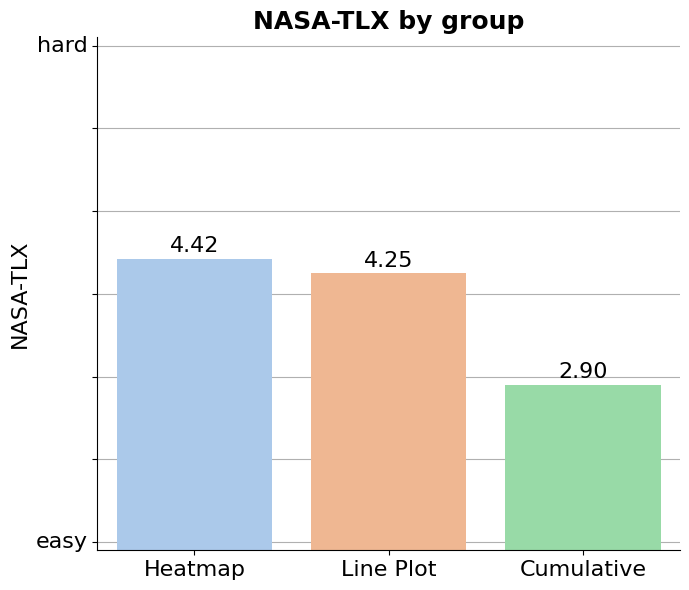

In [71]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.barplot(data=df_corr_help, x='group', y='NASA_TLX', hue='group', errorbar=None, palette='pastel', ax=ax)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.03,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=16
            )


ax.set_ylabel('NASA-TLX', fontsize=16)
ax.set_title('NASA-TLX by group', fontsize=18, fontweight='semibold')
ax.set_ylim(0.9, 7.1)
yticks = np.arange(1, 8)
ytick_labels = [''] * len(yticks)
ytick_labels[0] = 'easy'
ytick_labels[-1] = 'hard'
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, va='center')

ax.set_xlabel('')
ax.tick_params(axis='both', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("/Users/maximilianveitl/Downloads/nasa.png", dpi=300, bbox_inches='tight')

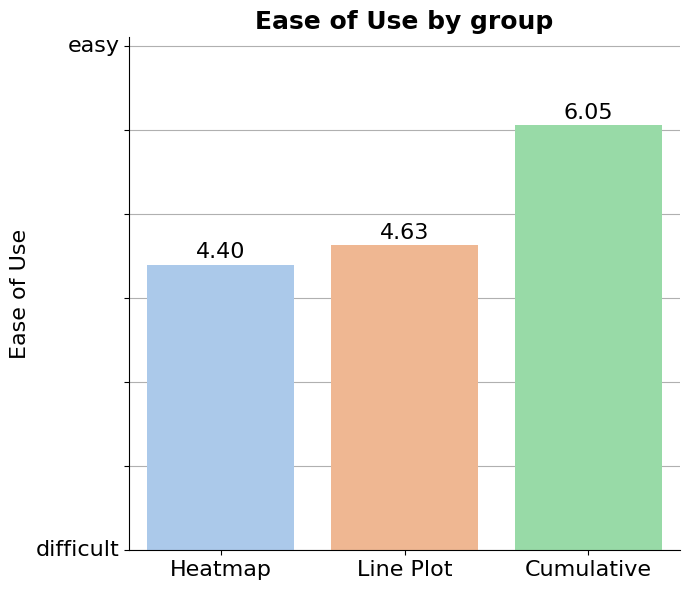

In [72]:
df_ease_of_use_scores = ease_of_use_scores.reset_index()
df_ease_of_use_scores.rename(columns={0: 'EOU'}, inplace=True)

df_ease_of_use_scores['group'] = df_ease_of_use_scores['group'].map({'base': 'A', 'Lineplot': 'B', 'Cumulative': 'C'})
df_ease_of_use_scores = df_ease_of_use_scores.sort_values(by=['group']).reset_index(drop=True)
df_ease_of_use_scores['group'] = df_ease_of_use_scores['group'].map({'A': 'Heatmap', 'B': 'Line Plot', 'C': 'Cumulative'})

fig, ax = plt.subplots(figsize=(7, 6))

sns.barplot(data=df_ease_of_use_scores, x='group', y='EOU', hue='group', palette='pastel')
# Mittelwert-Beschriftung
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.03,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=16
            )

# Achsen & Layout
ax.set_ylabel('Ease of Use', fontsize=16)
ax.set_title('Ease of Use by group', fontsize=18, fontweight='semibold')
ax.set_ylim(1, 7.1)
yticks = np.arange(1, 8)
ytick_labels = [''] * len(yticks)
ytick_labels[0] = 'difficult'
ytick_labels[-1] = 'easy'
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, va='center')

ax.set_xlabel('')
ax.tick_params(axis='both', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("/Users/maximilianveitl/Downloads/eou.png", dpi=300, bbox_inches='tight')